# Duck Egg Quality Classification Based on its Shell Visual Property through Image Processing and Deep Learning


## [Group CGM] PART 1 - Hyperparameter Tuning 

Group CGM: <br>

Caguioa, JV Bryan <br>
Guinto, Ryhle Nodnyhlson <br>
Mesias, Lee Reuben

## Imports

In [1]:
# the directory where the data is stored
directory = "C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis 2/Dataset"
#directory where set of models per training are stored
gen_dir = "C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis 2/Model"

import os                                              # define and move to dataset and model directory
import random                                          # for image name
import shutil                                          # dupli
import sys
import cv2     

import tensorflow.keras as keras
import numpy as np
import tensorflow as tf                                 #for callbacks
import seaborn as sn
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt                         #histograph/confusion matrix

from sklearn.model_selection import StratifiedKFold     #k-fold cross validation
from sklearn.model_selection import train_test_split    #split the dataset to train-test

from tensorflow.keras.preprocessing.image import ImageDataGenerator      # data augmentation
from tensorflow.keras.preprocessing import image as im                   #load image
from tensorflow.keras.applications.resnet50 import preprocess_input      #preprocess image                                                               

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc       
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import label_binarize

from scipy import interp                            #interpolation needed for plotting all classes into one roc plot
from itertools import cycle                         #for the color of lines on that multiclass plot

import warnings
warnings.filterwarnings("ignore")

## Put Dataset in a Dataframe

The directory of the images are put in a dataframe in order to prepare for splitting the dataset into train and test set.

In [2]:
totaldsdirect = directory + "/CombinedTwoAngleEggs"

image = []

if not os.path.exists(totaldsdirect):
    print("Directory does not exist. Please run the code on data cleaning notebook.")
    sys.exit()

for x in os.listdir(totaldsdirect):
    totaldsdirect2 = totaldsdirect + "/" + x
    for y in os.listdir(totaldsdirect2):
        if x == "Balut-penoy2":
            lbl = "0"
        elif x == "Salted egg2":
            lbl = "1"
        else:
            lbl = "2"
                 
        #append to image array
        image.append([totaldsdirect2 + "/" + y,lbl])

In [3]:
df = pd.DataFrame(image,columns=['filename','label'])
df

filename label
0    C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     0
1    C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     0
2    C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     0
3    C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     0
4    C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     0
..                                                 ...   ...
595  C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     2
596  C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     2
597  C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     2
598  C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     2
599  C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     2

[600 rows x 2 columns]

Classes: <br>
0 - Balut/Penoy <br> 
1 - Salted <br>
2 - Table

## Split Data to train and test set

We will need to split the dataset to train and test set. Only the train set will be used for transfer learning with K-fold validation. Test set will be used for model prediction and use that for model evaluation. Stratify is used in order to split the data in equal numbers under the classes specified.

In [4]:
# Split the data to train and test
X = df[['filename']]
y = df[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=420)

Save the split sets to train and test set folders.

In [5]:
#folder to store the train and test set folders
fortraintest = directory + "/ToBeUsed"
if not os.path.exists(fortraintest):
    os.makedirs(fortraintest)

#train set folder
tr = fortraintest + "/train_set"
if not os.path.exists(tr):
    os.makedirs(tr)
else:
    #remove previous folder and create new one
    shutil.rmtree(tr)
    os.makedirs(tr)
    
#test set folder
te = fortraintest + "/test_set"
if not os.path.exists(te):
    os.makedirs(te)
else:
    #remove previous folder and create new one
    shutil.rmtree(te)
    os.makedirs(te)

#copying the images to the train set folder
for index, row in X_train.iterrows():
    trcpy = shutil.copy2(row['filename'], tr)
    X_train.loc[X_train['filename']==row['filename'],'filename']=trcpy #change to directory where image is copied
    
#copying the images to the test set folder
for index, row in X_test.iterrows():
    tecpy = shutil.copy2(row['filename'], te)
    X_test.loc[X_test['filename']==row['filename'],'filename']=tecpy #change to directory where image is copiedb

In [6]:
df2 = pd.concat([X_train,y_train],axis=1)
df2

filename label
11   C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     0
581  C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     2
377  C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     1
487  C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     2
216  C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     1
..                                                 ...   ...
273  C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     1
486  C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     2
86   C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     0
200  C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     1
538  C:/Users/RAZER-MERCURY/Documents/Thesis/Thesis...     2

[540 rows x 2 columns]

## Functions

### Create Plot History

Plot history will display the training and validation accuracy, and training and validation loss in every epoch in a fold.

In [7]:
def plot_history(history, yrange):
    #Plot loss and accuracy as a function of the epoch,
    #for the training and validation datasets.
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.legend(['train_accuracy','val_accuracy'])
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.legend(['train_loss','val_loss'])
    
    plt.show() 

### Save Models

K-fold cross validation will be used in training the model.The set of models produced per fold will be saved in an automatic generated folder. Every training will generated another folder to save the new set of models.

In [8]:
def savemodel():
    save_cur = ""  #check if there is any saved_models folders

    svnum = 0
    svnum2 = 0

    for x in os.listdir(gen_dir):
        if "saved_models" in x:
            save_cur = x
            if not save_cur == "":
                for word in save_cur.split("_"):
                    if word.isdigit():
                        svnum2 = int(word)
                        if svnum < svnum2:
                            svnum = svnum2


    #save_dir is where the created models using the current set of parameters are added        
    if save_cur == "":
        save_dir = gen_dir + "/saved_models_1"
        os.makedirs(save_dir)
    else:
        save_dir = gen_dir + "/saved_models_" + str(svnum + 1)
        os.makedirs(save_dir)
        
    return save_dir

## Data Augmentation

We will apply data augmentation of the dataset per epoch in order to increase the accuracy of the models

In [9]:
resnet50 = keras.applications.resnet50

imgdatagen = ImageDataGenerator(
        preprocessing_function = resnet50.preprocess_input,
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = 10,
        height_shift_range = 10,
        rotation_range = 5,
        brightness_range = [0.8,1.3],
        fill_mode = "nearest"
    )

## Model Creation

The model will be based on ResNet50 Architecture. The classifier block will be changed to suit to our dataset.

In [10]:
def create_model():
    conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

    for layer in conv_model.layers:
        layer.trainable = False

    x = keras.layers.GlobalAveragePooling2D()(conv_model.output)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    predictions = keras.layers.Dense(3, activation='softmax')(x)

    full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

    return full_model

In [11]:
full_model = create_model()
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Hyper-Parameter Tuning

We will check the parameters that yielded the best results. A set of values on chosen parameters is given. The one that will yield the best results will be used for prediction.

### Model Parameters

In [12]:
batch_size_arr = [8,16,32]                              #batch size
num_epochs_arr = [50,70,90,110]                       #number of epochs
lr_arr = [0.0001,0.00001]                                 #learning rate Adamax

### Initialize Variables

In [13]:
VALIDATION_ACCURACY = []                          #holds all validation_accuracy
VALIDATION_LOSS = []                              #holds all validation_loss

TRAIN_ACCURACY = []                               #holds all train_accuracy
TRAIN_LOSS = []                                   #holds all train_loss

TEST_ACCURACY = []                                #holds all test_accuracy
TEST_LOSS = []                                    #holds all test_loss

param_arr = []                                    #holds the parameter values per combination

val_acc_arr = []                                  #holds the set of validation accuracy per combination
val_loss_arr = []                                 #holds the set of validation loss per combination
val_acc_means = []                                #holds the means of all set of validation accuracy per combination
val_loss_means = []                               #holds the means of all set of validation loss per combination

train_acc_arr = []                                #holds the set of train accuracy per combination
train_loss_arr = []                               #holds the set of train loss per combination
train_acc_means = []                              #holds the means of all set of train accuracy per combination
train_loss_means = []                             #holds the means of all set of train loss per combination

test_acc_arr = []                                 #holds the set of test accuracy per combination
test_loss_arr = []                                #holds the set of test loss per combination
test_acc_means = []                               #holds the means of all set of test accuracy per combination
test_loss_means = []                              #holds the means of all set of test loss per combination

### Train, Validation, Test data settings

In [14]:
train_dir = directory + "/ToBeUsed/train_set"     #where the train set images are stored
test_dir = directory + "/ToBeUsed/test_set"

#kfold parameters
Y = df2[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 69, shuffle = True)

testX = []

for img_path in X_test['filename']:
    img = im.load_img(img_path, target_size=(224,224))
    x = im.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = x.reshape(224,224,3)
    testX.append(x)

testX = np.array(testX)

yt = pd.to_numeric(y_test['label'])                #make the labels to integer to get the model metrics

Train the model per combination of parameters.


batch size:  8
epochs:  50
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


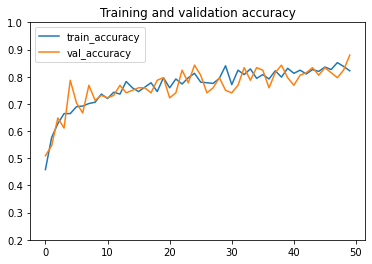

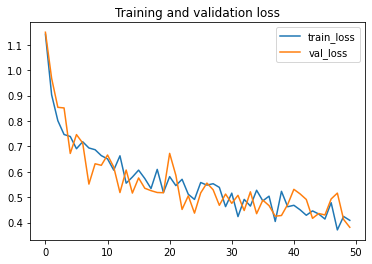

14/14 [==============================] - 1s 81ms/step - loss: 0.4575 - accuracy: 0.8241

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


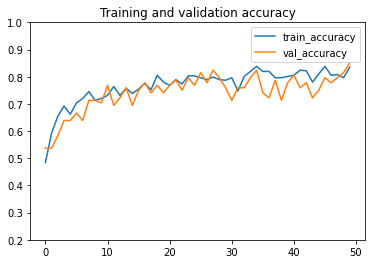

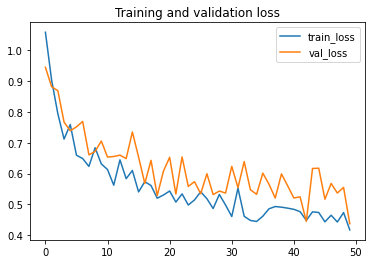

14/14 [==============================] - 1s 82ms/step - loss: 0.5166 - accuracy: 0.7778

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


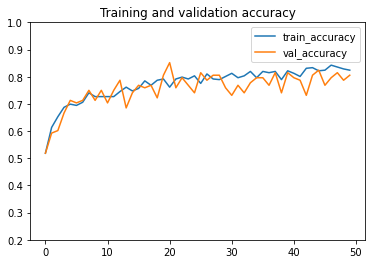

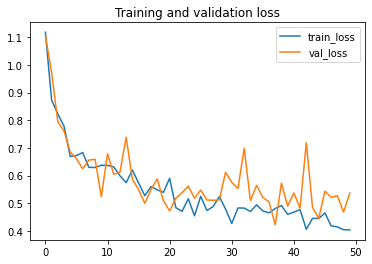

14/14 [==============================] - 1s 85ms/step - loss: 0.4747 - accuracy: 0.8241

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


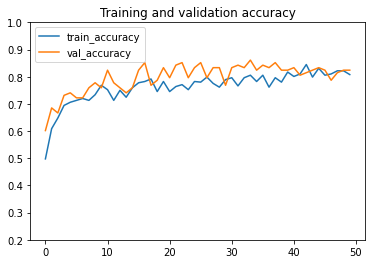

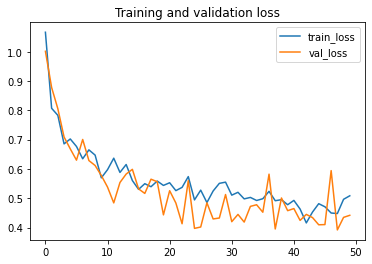

14/14 [==============================] - 1s 78ms/step - loss: 0.3962 - accuracy: 0.8426

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


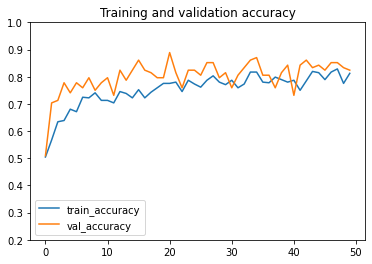

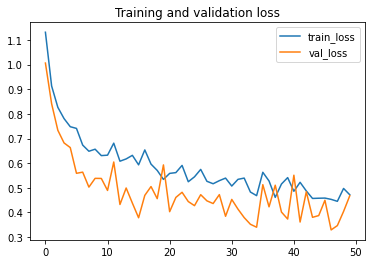

14/14 [==============================] - 1s 81ms/step - loss: 0.3368 - accuracy: 0.8611

batch size:  8
epochs:  50
learning rate:  1e-05


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


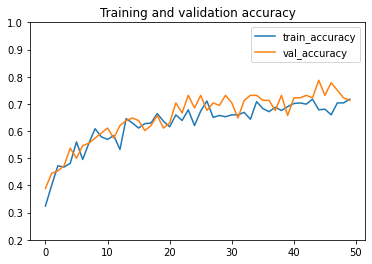

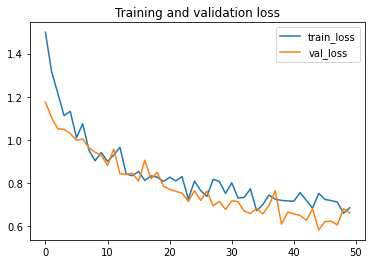

14/14 [==============================] - 1s 81ms/step - loss: 0.6453 - accuracy: 0.7778

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


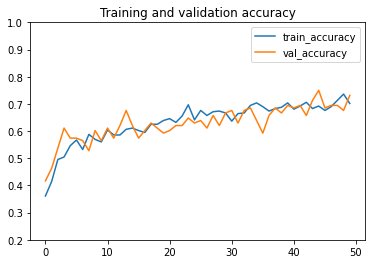

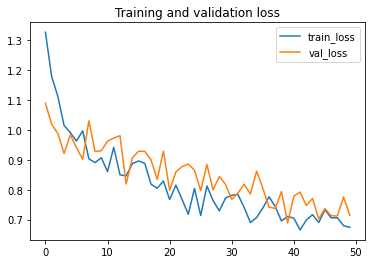

14/14 [==============================] - 1s 92ms/step - loss: 0.7220 - accuracy: 0.7500

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


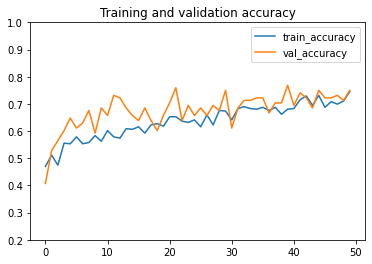

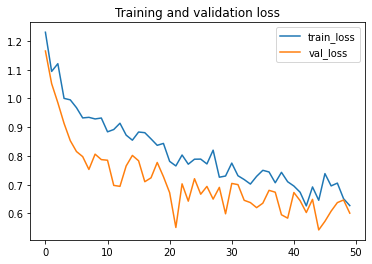

14/14 [==============================] - 1s 84ms/step - loss: 0.6268 - accuracy: 0.7130

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


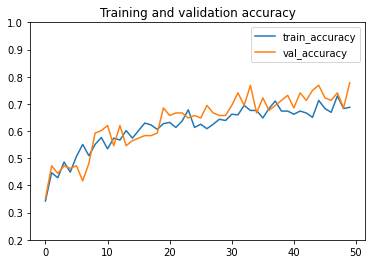

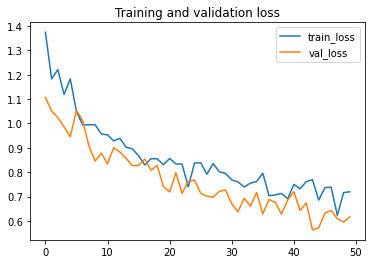

14/14 [==============================] - 1s 79ms/step - loss: 0.7342 - accuracy: 0.6759

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


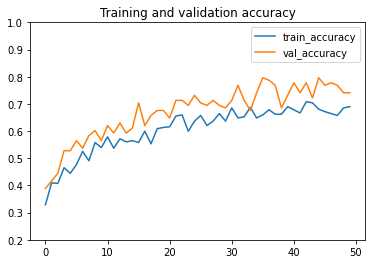

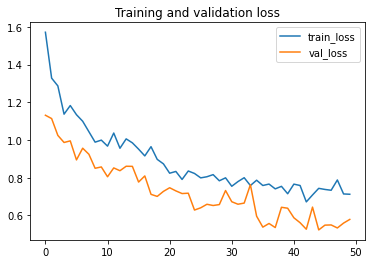

14/14 [==============================] - 1s 81ms/step - loss: 0.6318 - accuracy: 0.6944

batch size:  8
epochs:  70
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


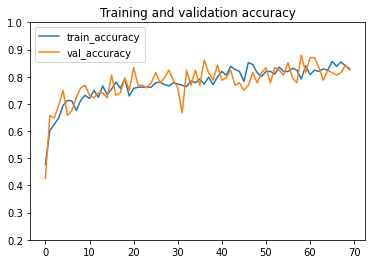

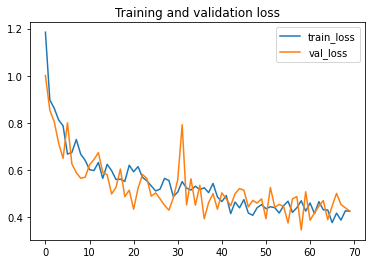

14/14 [==============================] - 1s 79ms/step - loss: 0.4677 - accuracy: 0.8056

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


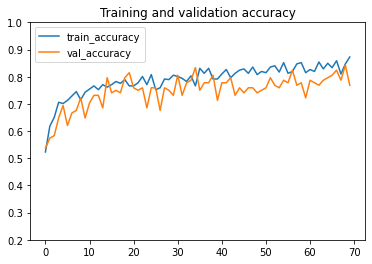

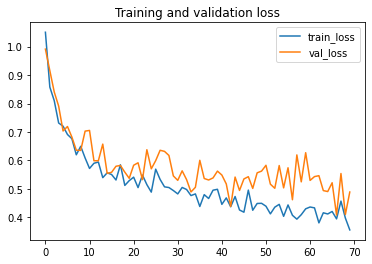

14/14 [==============================] - 1s 80ms/step - loss: 0.5326 - accuracy: 0.7500

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


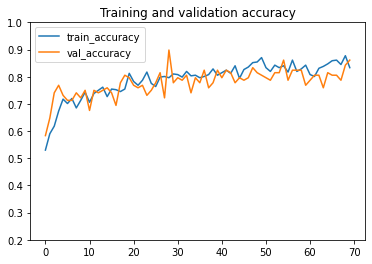

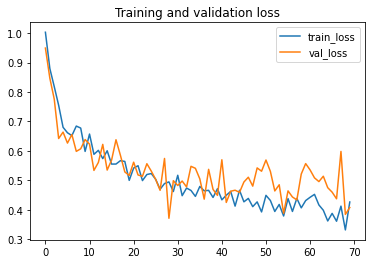

14/14 [==============================] - 1s 81ms/step - loss: 0.4684 - accuracy: 0.7870

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


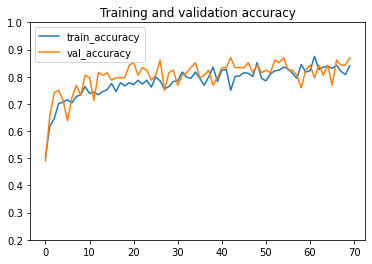

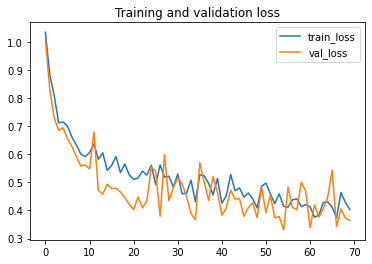

14/14 [==============================] - 1s 81ms/step - loss: 0.3591 - accuracy: 0.8611

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


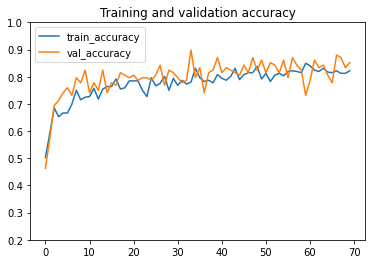

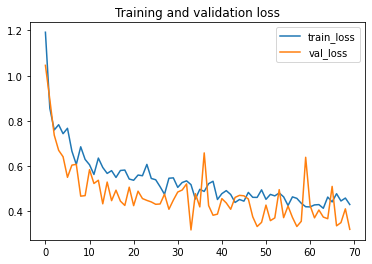

14/14 [==============================] - 1s 81ms/step - loss: 0.4008 - accuracy: 0.8241

batch size:  8
epochs:  70
learning rate:  1e-05


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


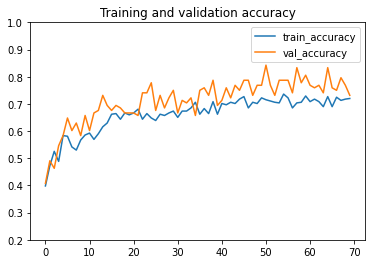

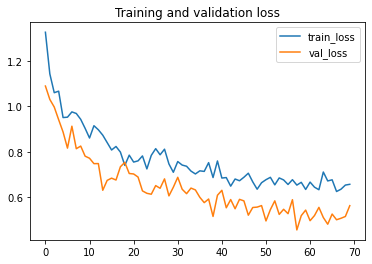

14/14 [==============================] - 1s 82ms/step - loss: 0.5334 - accuracy: 0.7593

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


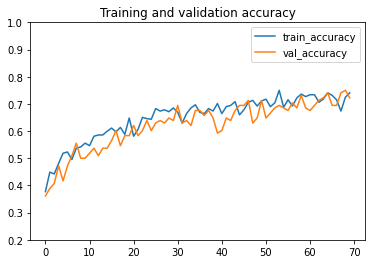

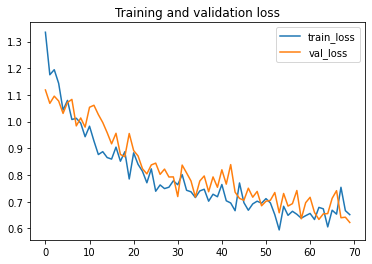

14/14 [==============================] - 1s 80ms/step - loss: 0.6708 - accuracy: 0.7130

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


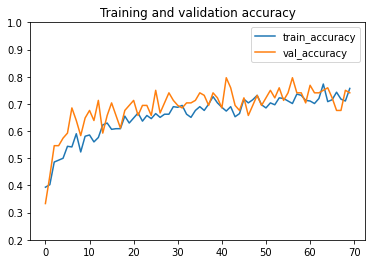

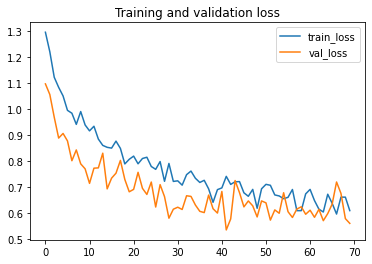

14/14 [==============================] - 1s 82ms/step - loss: 0.6675 - accuracy: 0.7315

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


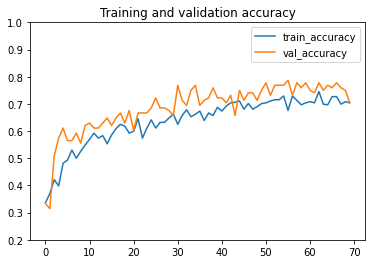

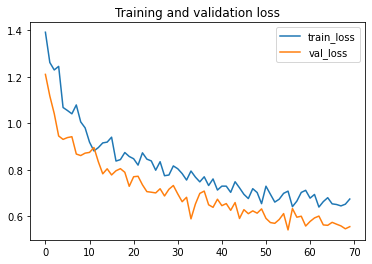

14/14 [==============================] - 1s 80ms/step - loss: 0.6501 - accuracy: 0.7407

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


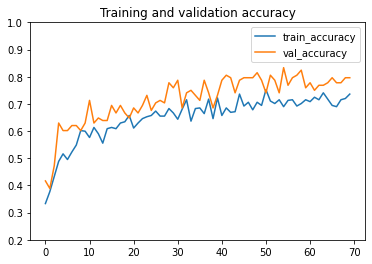

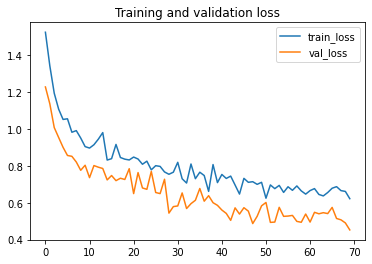

14/14 [==============================] - 1s 82ms/step - loss: 0.4930 - accuracy: 0.7593

batch size:  8
epochs:  90
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


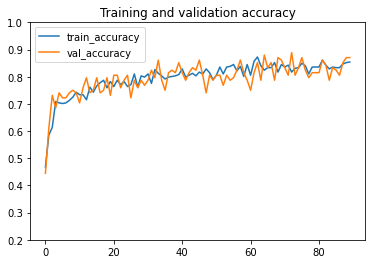

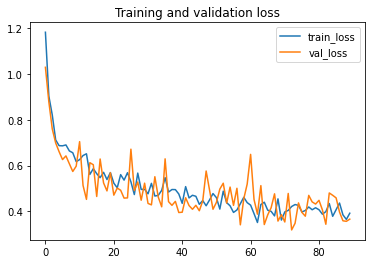

14/14 [==============================] - 1s 82ms/step - loss: 0.3650 - accuracy: 0.8426

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


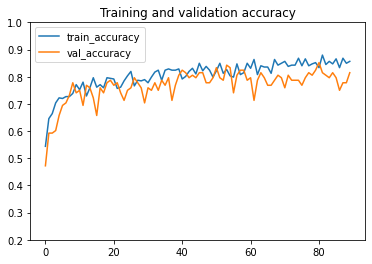

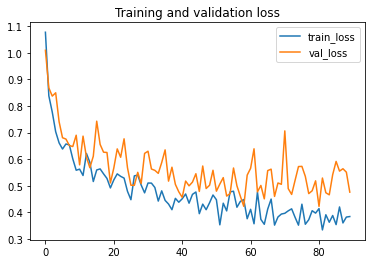

14/14 [==============================] - 1s 82ms/step - loss: 0.4554 - accuracy: 0.8056

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


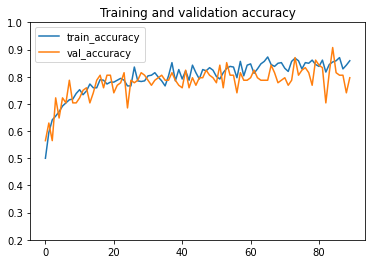

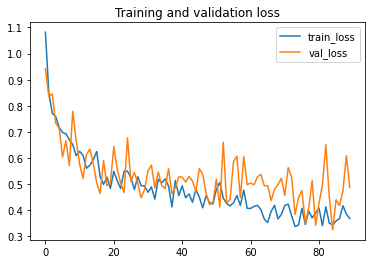

14/14 [==============================] - 1s 83ms/step - loss: 0.3826 - accuracy: 0.8426

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


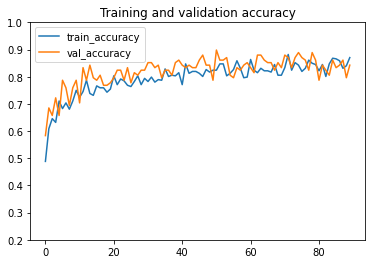

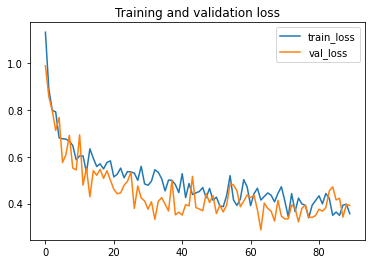

14/14 [==============================] - 1s 82ms/step - loss: 0.3559 - accuracy: 0.8611

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


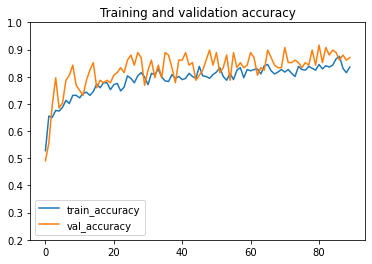

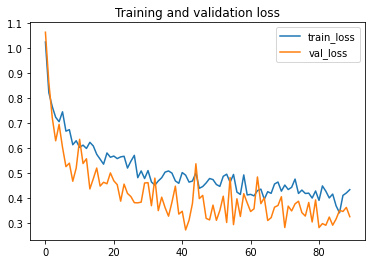

14/14 [==============================] - 1s 80ms/step - loss: 0.3577 - accuracy: 0.8148

batch size:  8
epochs:  90
learning rate:  1e-05


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


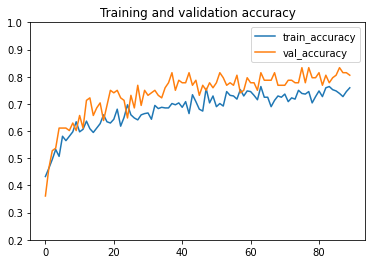

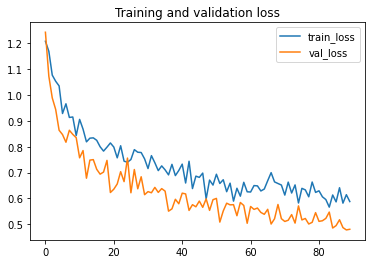

14/14 [==============================] - 1s 81ms/step - loss: 0.5652 - accuracy: 0.7870

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


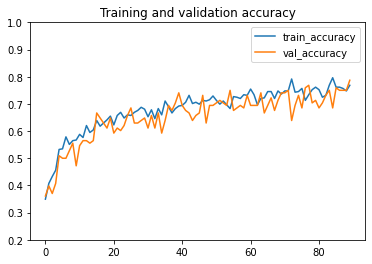

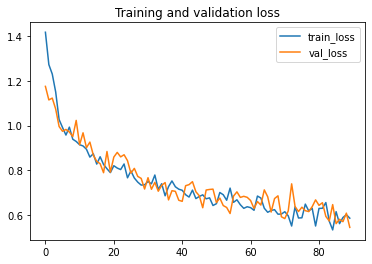

14/14 [==============================] - 1s 84ms/step - loss: 0.5722 - accuracy: 0.7685

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


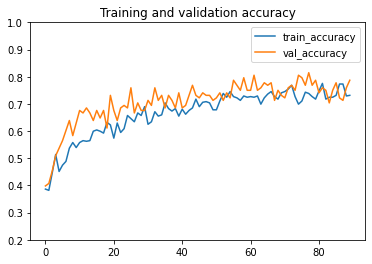

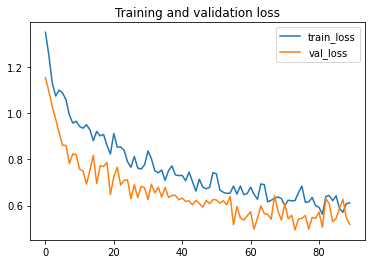

14/14 [==============================] - 1s 84ms/step - loss: 0.4609 - accuracy: 0.8426

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


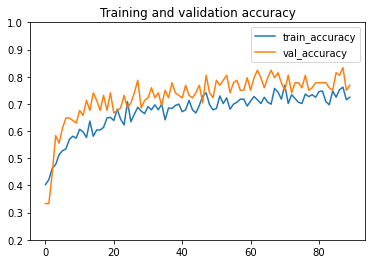

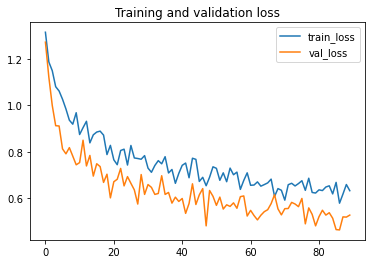

14/14 [==============================] - 1s 83ms/step - loss: 0.4804 - accuracy: 0.8241

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


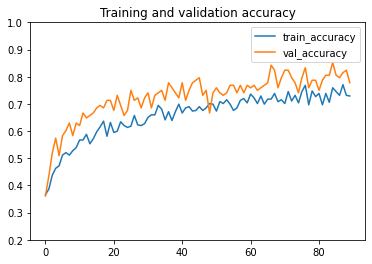

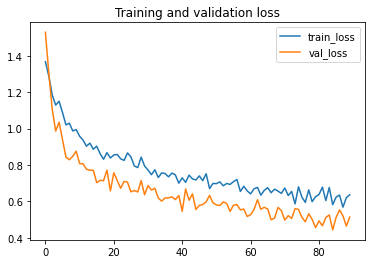

14/14 [==============================] - 1s 82ms/step - loss: 0.5033 - accuracy: 0.7593

batch size:  8
epochs:  110
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


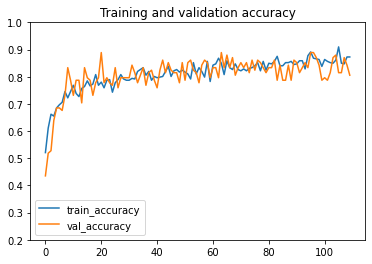

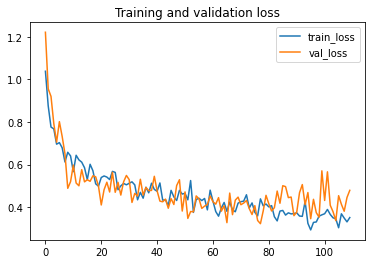

14/14 [==============================] - 1s 83ms/step - loss: 0.3537 - accuracy: 0.8333

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


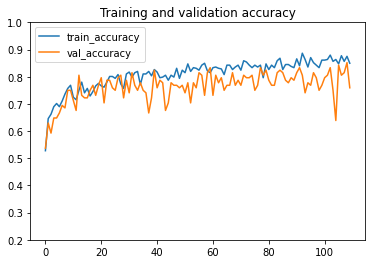

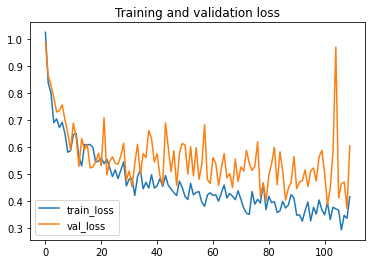

14/14 [==============================] - 1s 82ms/step - loss: 0.3913 - accuracy: 0.8148

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


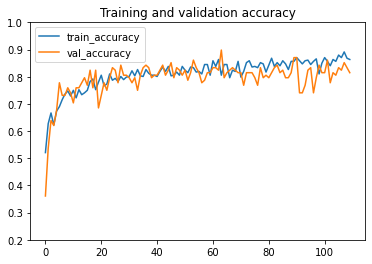

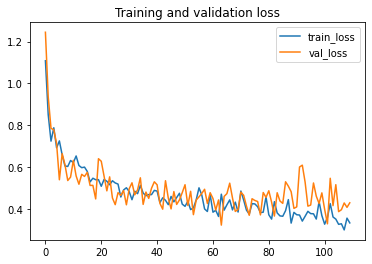

14/14 [==============================] - 1s 84ms/step - loss: 0.2939 - accuracy: 0.8889

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


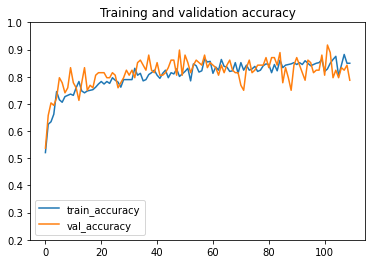

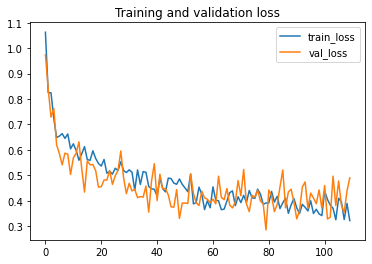

14/14 [==============================] - 1s 80ms/step - loss: 0.3852 - accuracy: 0.8426

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


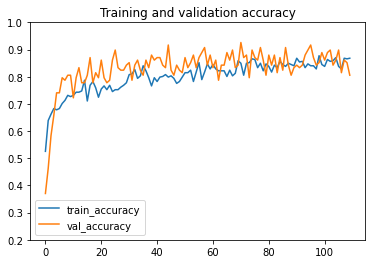

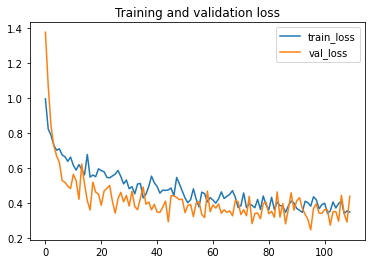

14/14 [==============================] - 1s 80ms/step - loss: 0.3639 - accuracy: 0.8704

batch size:  8
epochs:  110
learning rate:  1e-05


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


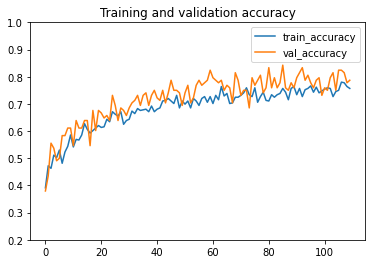

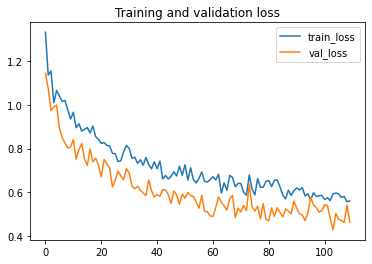

14/14 [==============================] - 1s 83ms/step - loss: 0.4462 - accuracy: 0.8056

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


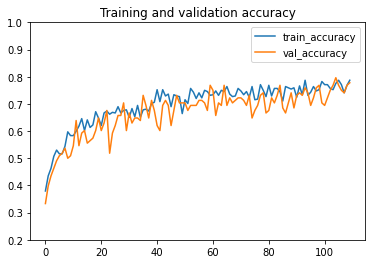

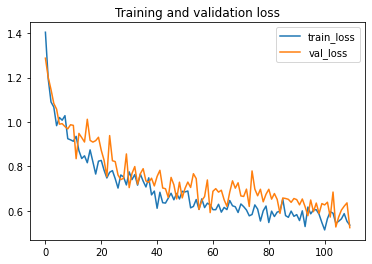

14/14 [==============================] - 1s 84ms/step - loss: 0.6288 - accuracy: 0.7500

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


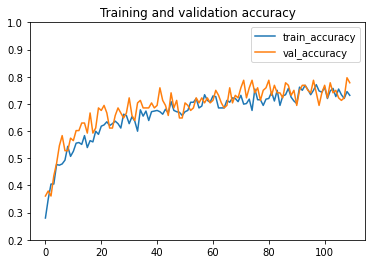

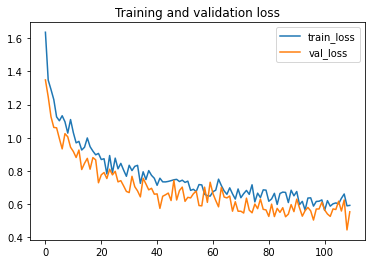

14/14 [==============================] - 1s 82ms/step - loss: 0.4506 - accuracy: 0.7963

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


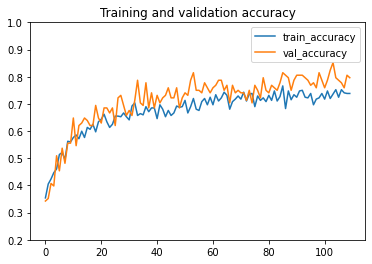

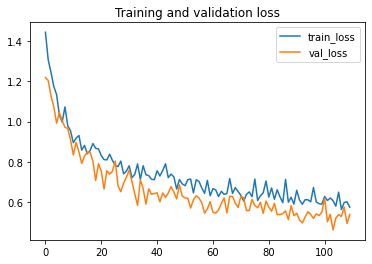

14/14 [==============================] - 1s 81ms/step - loss: 0.5074 - accuracy: 0.8148

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


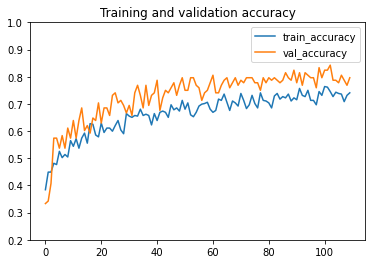

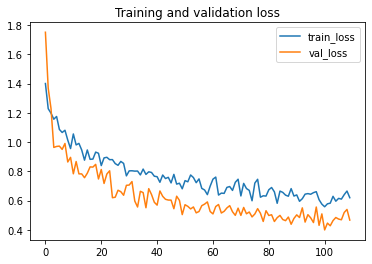

14/14 [==============================] - 1s 82ms/step - loss: 0.5908 - accuracy: 0.7963

batch size:  16
epochs:  50
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


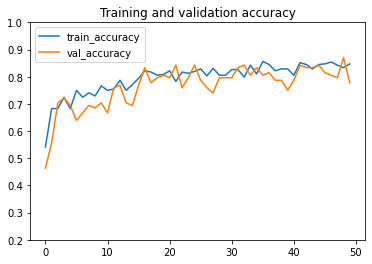

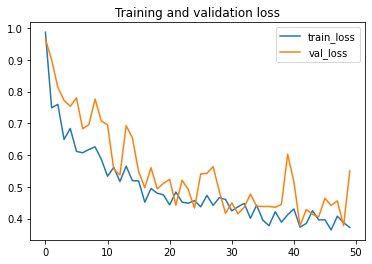

7/7 [==============================] - 1s 161ms/step - loss: 0.3500 - accuracy: 0.8519

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


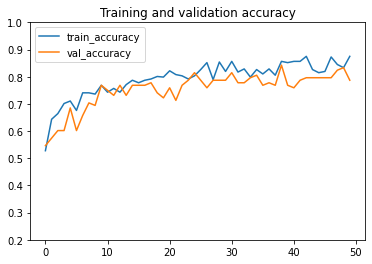

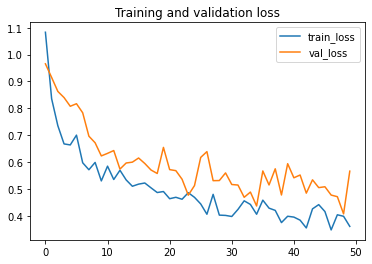

7/7 [==============================] - 1s 159ms/step - loss: 0.4361 - accuracy: 0.8426

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


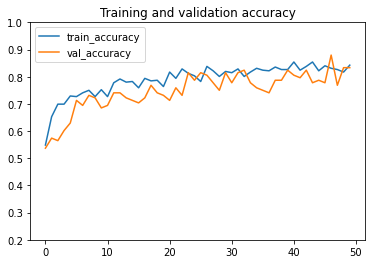

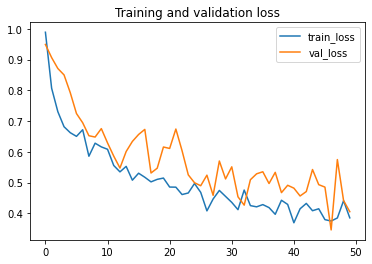

7/7 [==============================] - 1s 160ms/step - loss: 0.3835 - accuracy: 0.8148

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


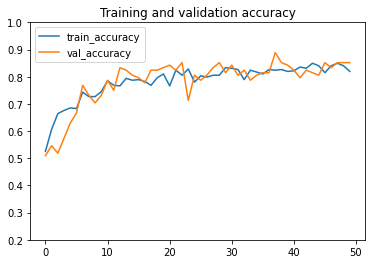

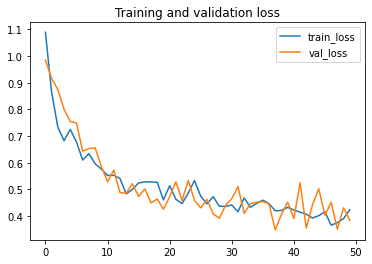

7/7 [==============================] - 1s 162ms/step - loss: 0.4337 - accuracy: 0.8704

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


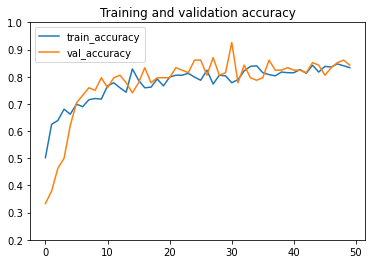

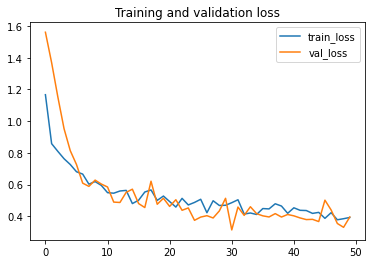

7/7 [==============================] - 1s 162ms/step - loss: 0.4188 - accuracy: 0.8611

batch size:  16
epochs:  50
learning rate:  1e-05


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


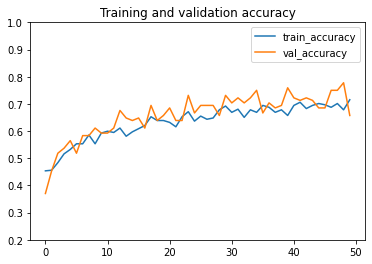

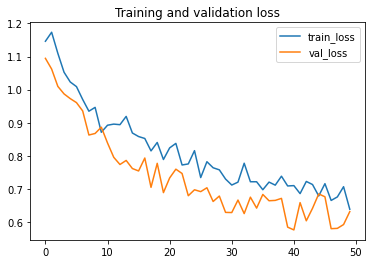

7/7 [==============================] - 1s 160ms/step - loss: 0.5659 - accuracy: 0.7778

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


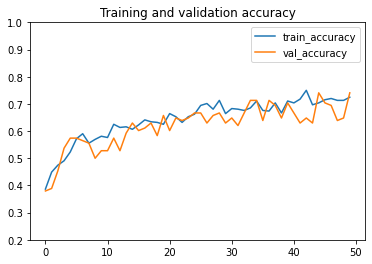

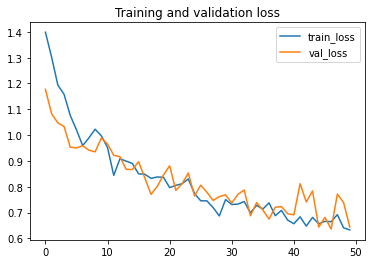

7/7 [==============================] - 1s 161ms/step - loss: 0.7133 - accuracy: 0.6389

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


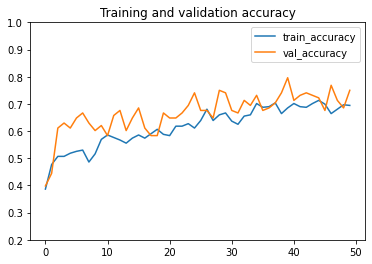

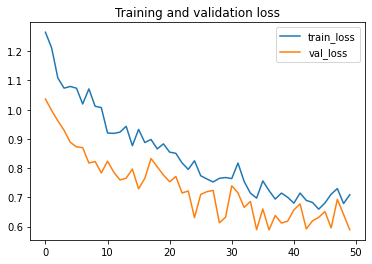

7/7 [==============================] - 1s 157ms/step - loss: 0.5873 - accuracy: 0.7037

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


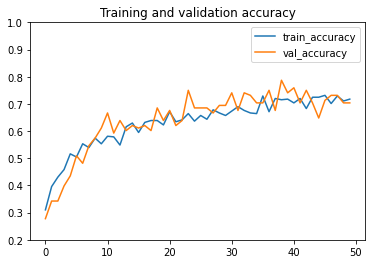

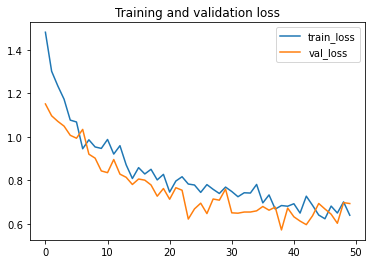

7/7 [==============================] - 1s 166ms/step - loss: 0.7379 - accuracy: 0.6574

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


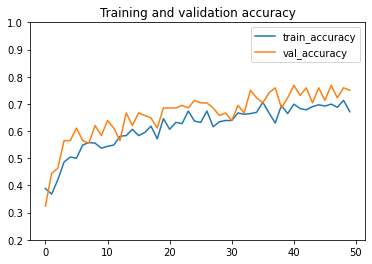

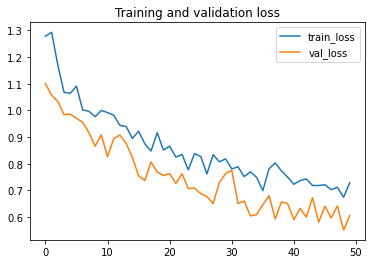

7/7 [==============================] - 1s 165ms/step - loss: 0.5671 - accuracy: 0.75000s - loss: 0.5855 - accuracy: 0.

batch size:  16
epochs:  70
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


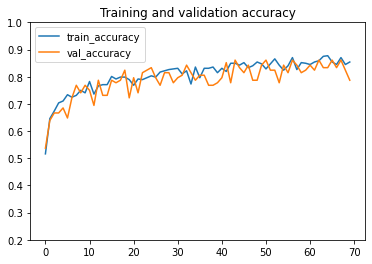

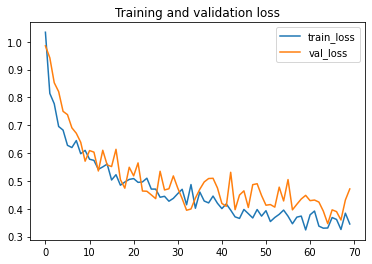

7/7 [==============================] - 1s 165ms/step - loss: 0.4079 - accuracy: 0.8426

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


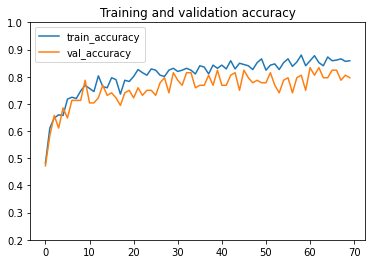

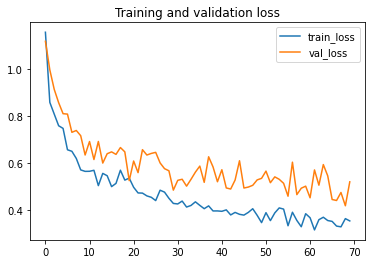

7/7 [==============================] - 1s 162ms/step - loss: 0.5292 - accuracy: 0.7963

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


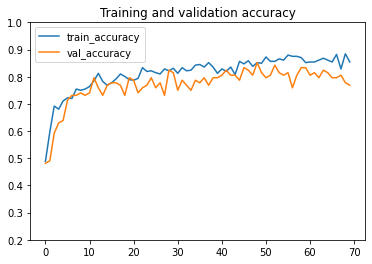

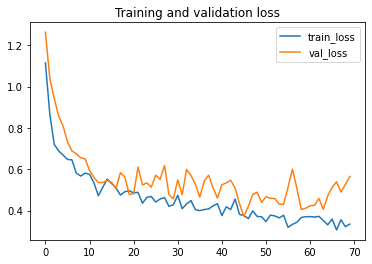

7/7 [==============================] - 1s 162ms/step - loss: 0.4204 - accuracy: 0.8426

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


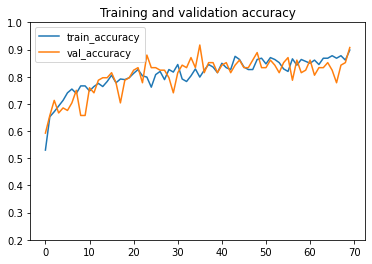

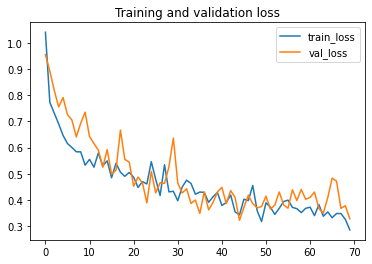

7/7 [==============================] - 1s 165ms/step - loss: 0.4039 - accuracy: 0.8519

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


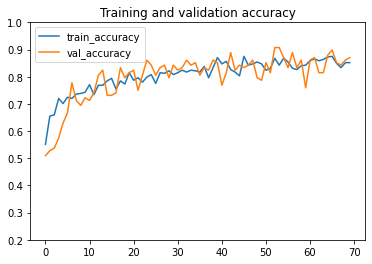

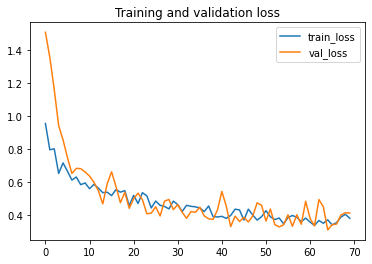

7/7 [==============================] - 1s 157ms/step - loss: 0.3243 - accuracy: 0.8796

batch size:  16
epochs:  70
learning rate:  1e-05


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


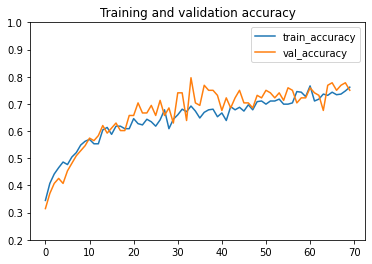

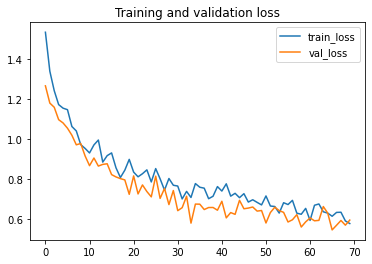

7/7 [==============================] - 1s 159ms/step - loss: 0.5810 - accuracy: 0.7407

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


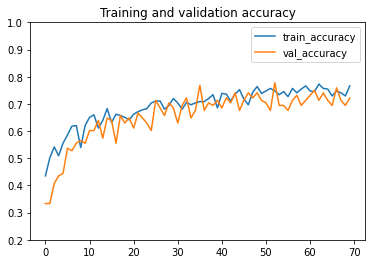

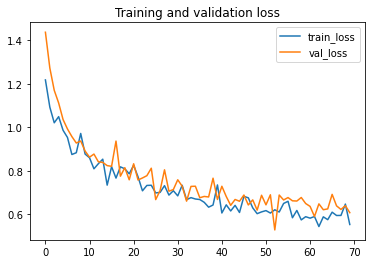

7/7 [==============================] - 1s 176ms/step - loss: 0.6058 - accuracy: 0.7407

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


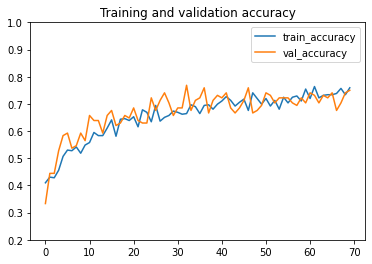

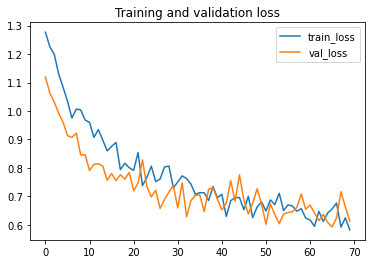

7/7 [==============================] - 1s 182ms/step - loss: 0.6138 - accuracy: 0.7315

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


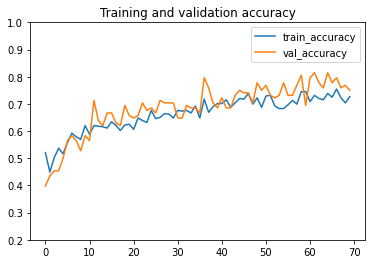

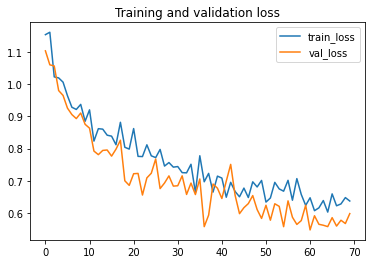

7/7 [==============================] - 1s 177ms/step - loss: 0.5041 - accuracy: 0.7963

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


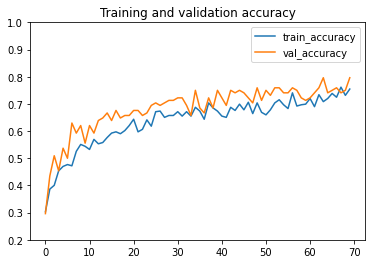

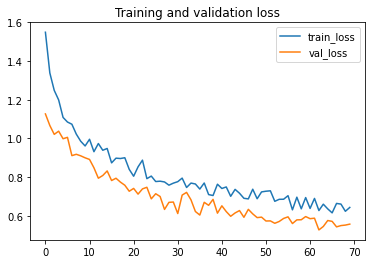

7/7 [==============================] - 1s 160ms/step - loss: 0.6078 - accuracy: 0.7130

batch size:  16
epochs:  90
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


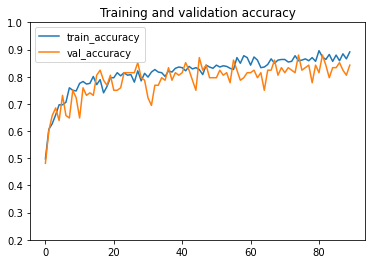

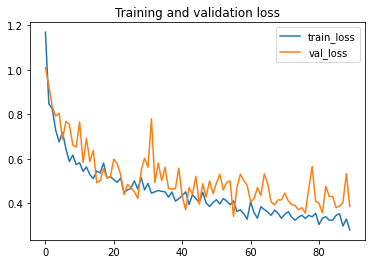

7/7 [==============================] - 1s 170ms/step - loss: 0.3484 - accuracy: 0.8611

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


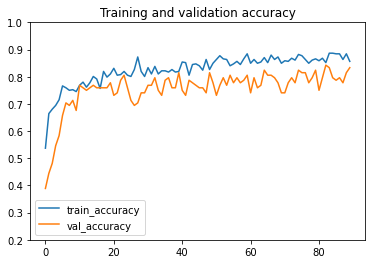

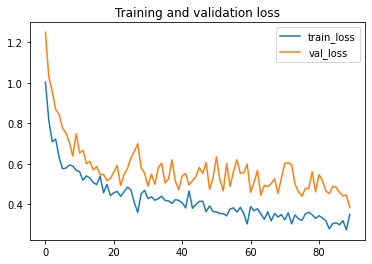

7/7 [==============================] - 1s 165ms/step - loss: 0.4154 - accuracy: 0.8241

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


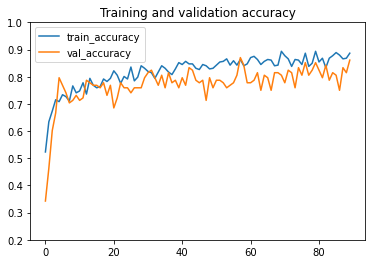

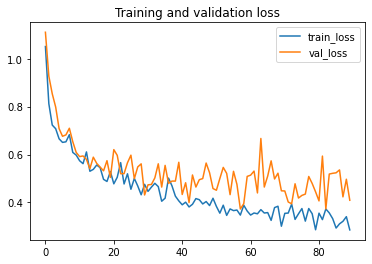

7/7 [==============================] - 1s 166ms/step - loss: 0.4773 - accuracy: 0.8241

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


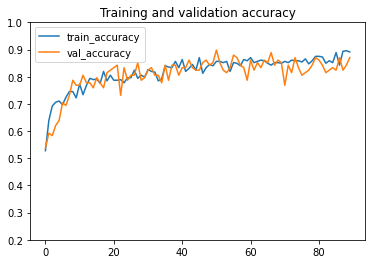

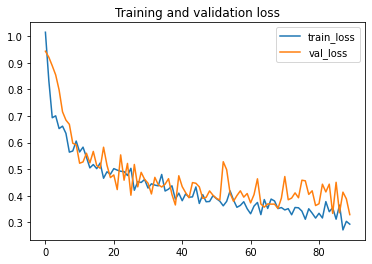

7/7 [==============================] - 1s 193ms/step - loss: 0.3889 - accuracy: 0.8333

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


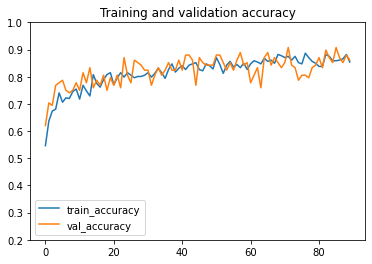

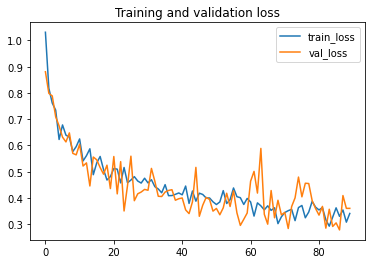

7/7 [==============================] - 1s 162ms/step - loss: 0.3168 - accuracy: 0.8889

batch size:  16
epochs:  90
learning rate:  1e-05


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


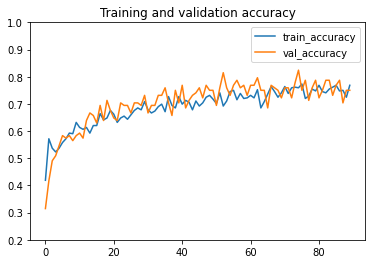

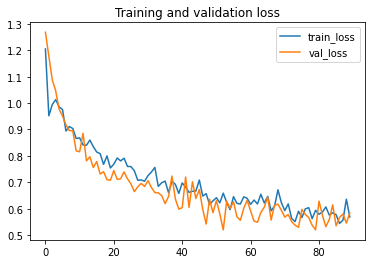

7/7 [==============================] - 1s 172ms/step - loss: 0.6465 - accuracy: 0.7222

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


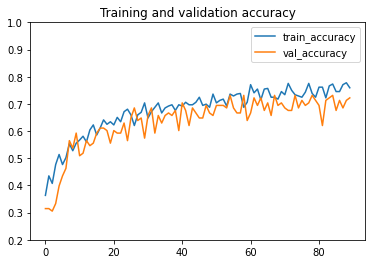

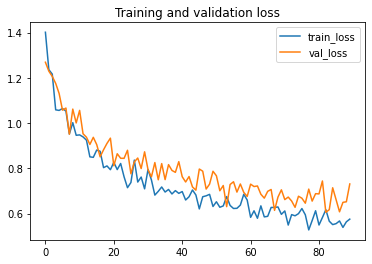

7/7 [==============================] - 1s 175ms/step - loss: 0.5745 - accuracy: 0.7500

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


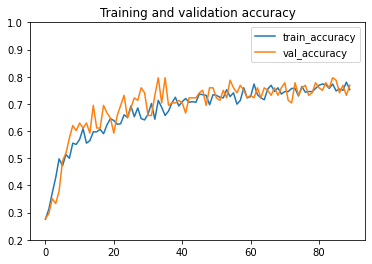

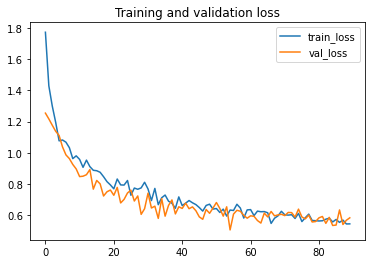

7/7 [==============================] - 1s 172ms/step - loss: 0.6828 - accuracy: 0.7222

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


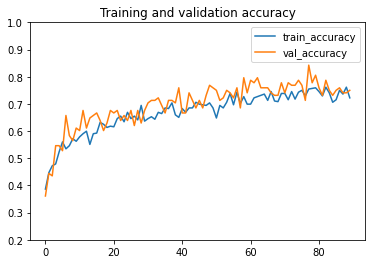

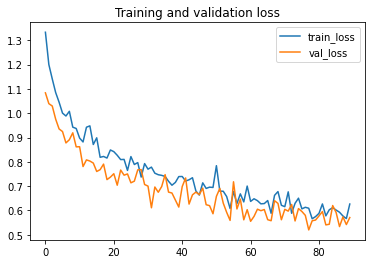

7/7 [==============================] - 1s 162ms/step - loss: 0.5701 - accuracy: 0.7778

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


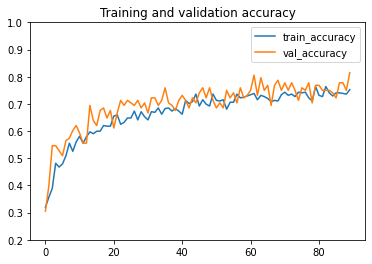

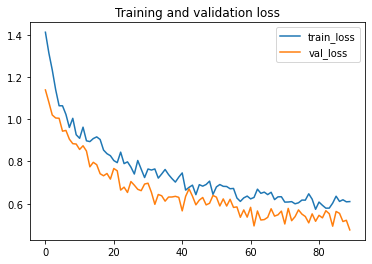

7/7 [==============================] - 2s 237ms/step - loss: 0.5024 - accuracy: 0.7685

batch size:  16
epochs:  110
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


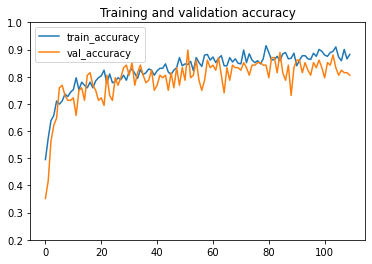

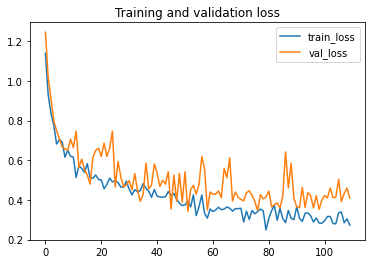

7/7 [==============================] - 1s 178ms/step - loss: 0.4236 - accuracy: 0.8056

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


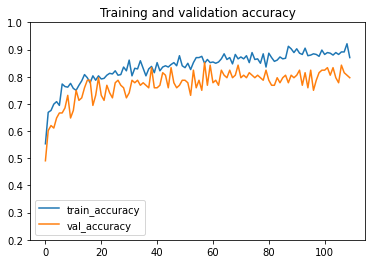

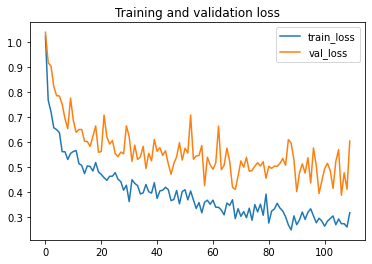

7/7 [==============================] - 1s 180ms/step - loss: 0.4096 - accuracy: 0.8426

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


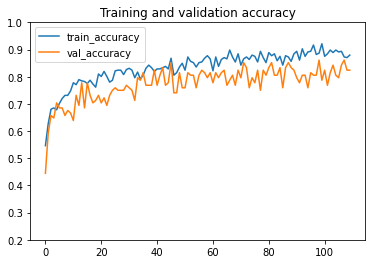

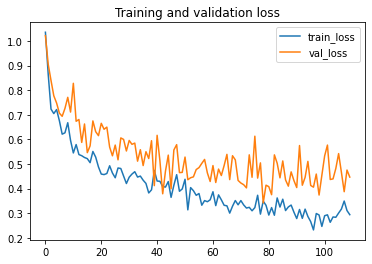

7/7 [==============================] - 1s 192ms/step - loss: 0.4460 - accuracy: 0.8148

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


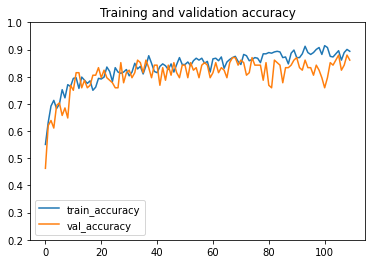

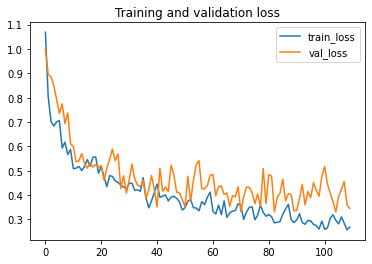

7/7 [==============================] - 1s 190ms/step - loss: 0.3146 - accuracy: 0.8889

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


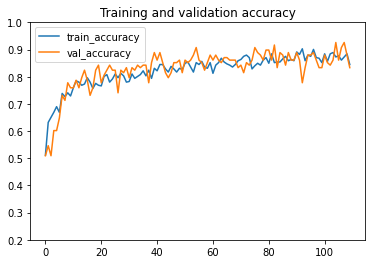

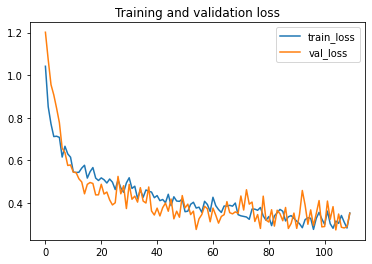

7/7 [==============================] - 1s 197ms/step - loss: 0.2729 - accuracy: 0.8889

batch size:  16
epochs:  110
learning rate:  1e-05


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


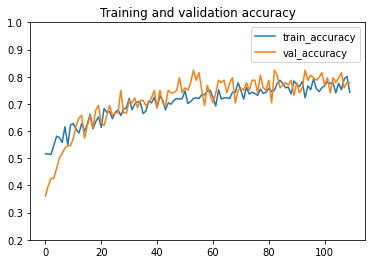

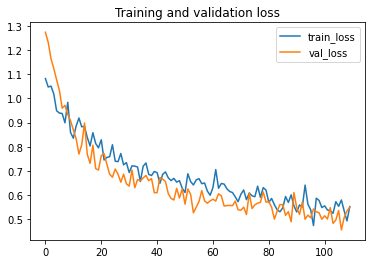

7/7 [==============================] - 1s 167ms/step - loss: 0.4708 - accuracy: 0.8333

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


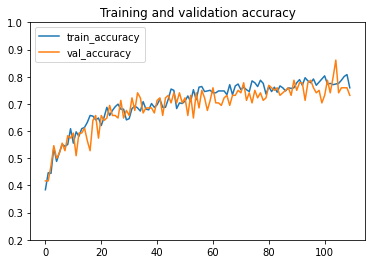

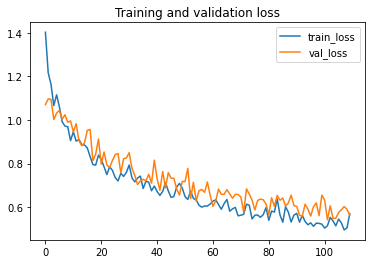

7/7 [==============================] - 1s 168ms/step - loss: 0.5871 - accuracy: 0.7685

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


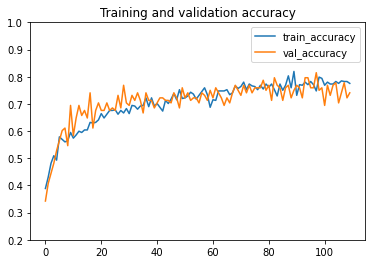

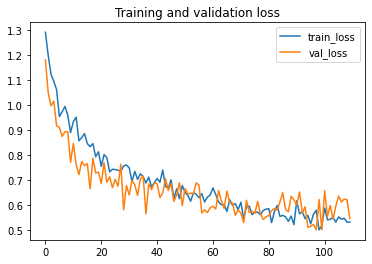

7/7 [==============================] - 1s 166ms/step - loss: 0.5627 - accuracy: 0.7222

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


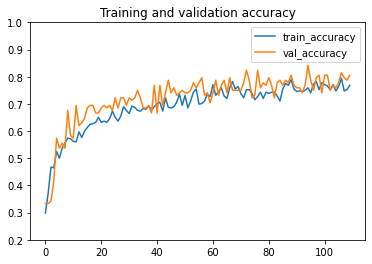

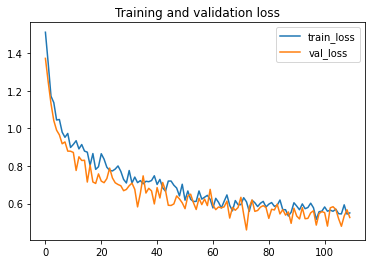

7/7 [==============================] - 1s 162ms/step - loss: 0.5318 - accuracy: 0.7778

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


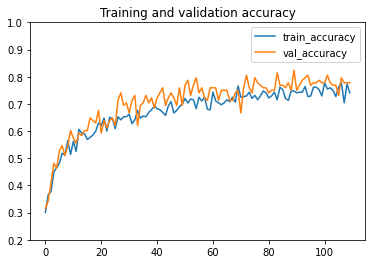

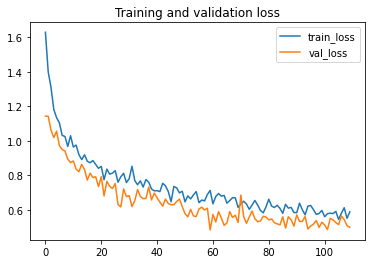

7/7 [==============================] - 1s 163ms/step - loss: 0.5747 - accuracy: 0.7593

batch size:  32
epochs:  50
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


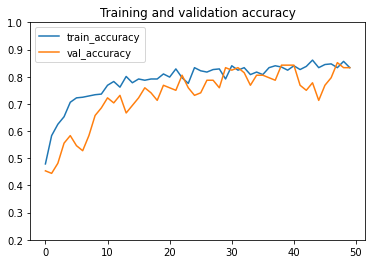

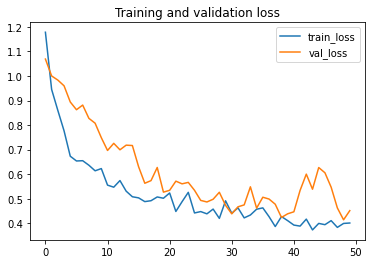

4/4 [==============================] - 1s 250ms/step - loss: 0.4555 - accuracy: 0.8426

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


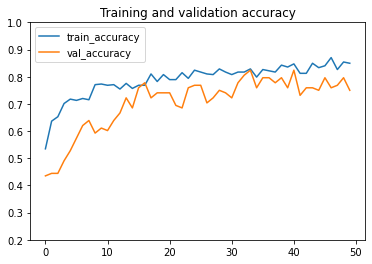

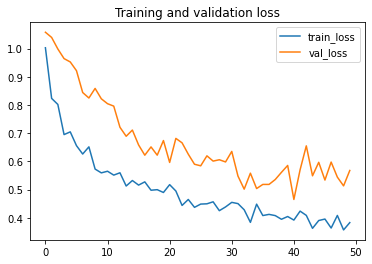

4/4 [==============================] - 1s 243ms/step - loss: 0.5468 - accuracy: 0.7778

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


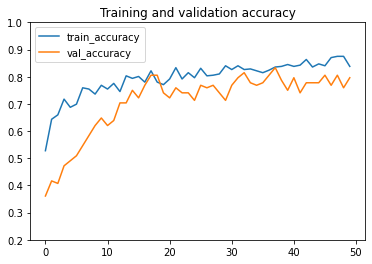

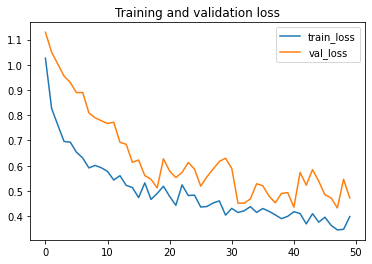

4/4 [==============================] - 1s 256ms/step - loss: 0.5367 - accuracy: 0.7870

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


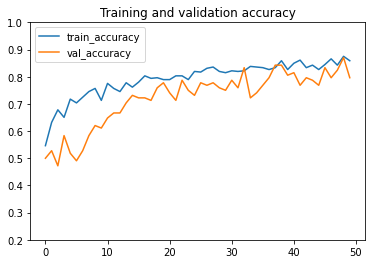

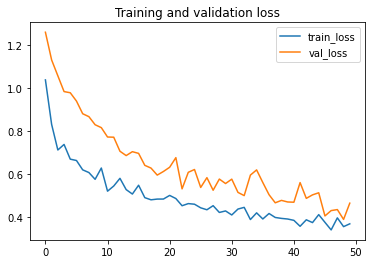

4/4 [==============================] - 1s 253ms/step - loss: 0.4120 - accuracy: 0.8333

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


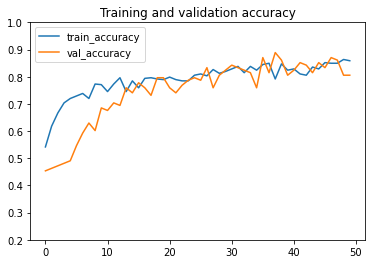

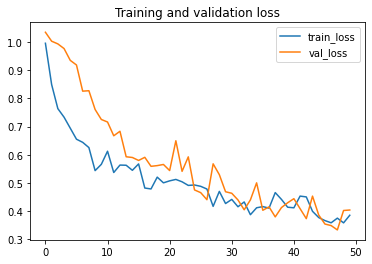

4/4 [==============================] - 1s 261ms/step - loss: 0.3470 - accuracy: 0.8519

batch size:  32
epochs:  50
learning rate:  1e-05


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


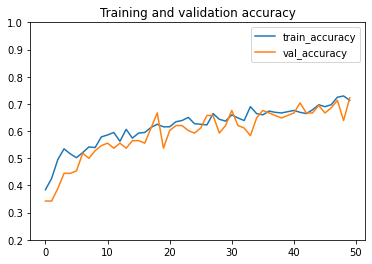

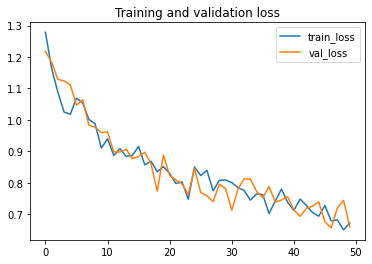

4/4 [==============================] - 1s 258ms/step - loss: 0.6782 - accuracy: 0.7315

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


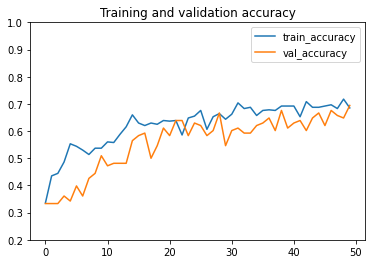

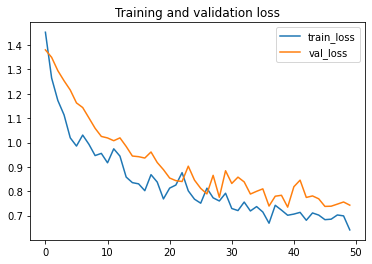

4/4 [==============================] - 1s 259ms/step - loss: 0.7799 - accuracy: 0.6111

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


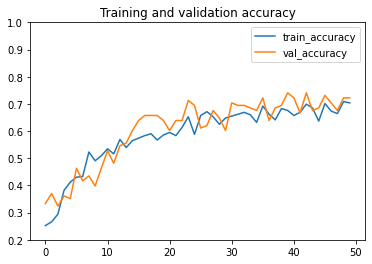

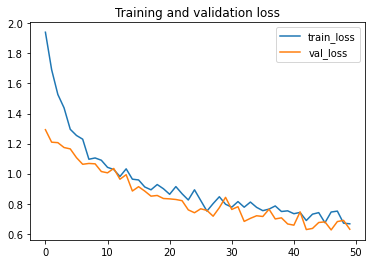

4/4 [==============================] - 1s 270ms/step - loss: 0.6463 - accuracy: 0.7315

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


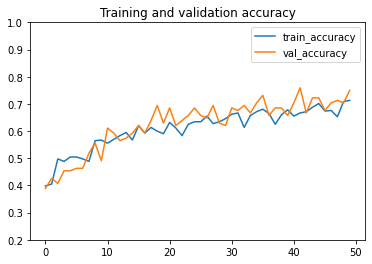

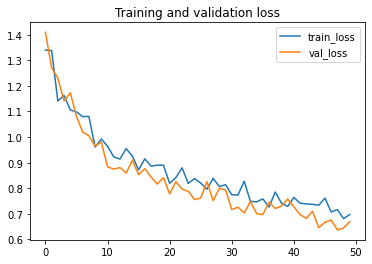

4/4 [==============================] - 1s 262ms/step - loss: 0.6944 - accuracy: 0.6667

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


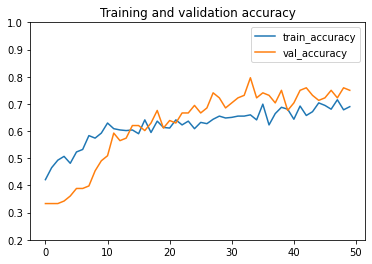

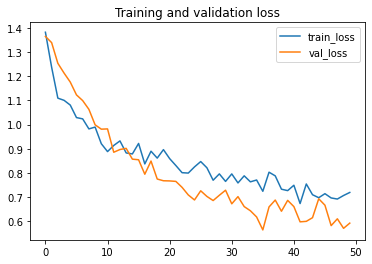

4/4 [==============================] - 1s 252ms/step - loss: 0.6979 - accuracy: 0.6667

batch size:  32
epochs:  70
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


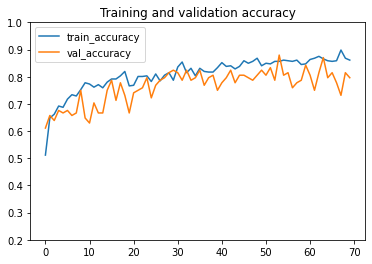

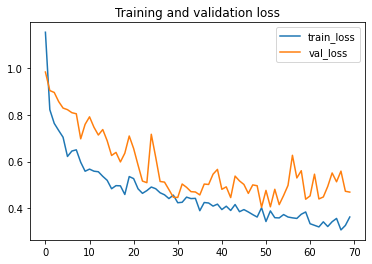

4/4 [==============================] - 1s 269ms/step - loss: 0.4806 - accuracy: 0.7963

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


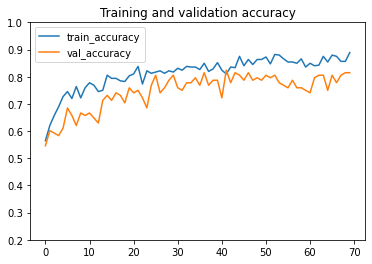

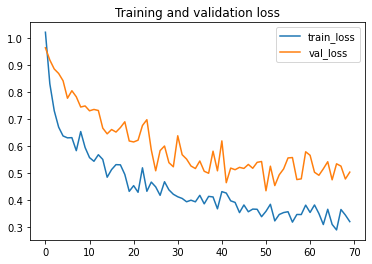

4/4 [==============================] - 1s 278ms/step - loss: 0.4738 - accuracy: 0.8056

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


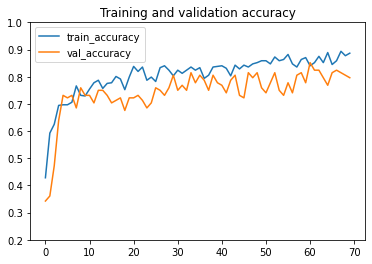

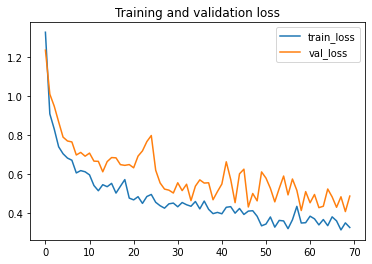

4/4 [==============================] - 1s 281ms/step - loss: 0.4788 - accuracy: 0.8519

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


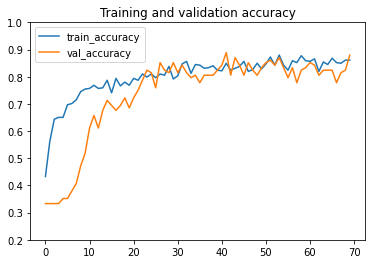

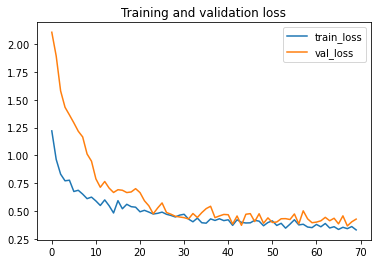

4/4 [==============================] - 1s 286ms/step - loss: 0.3993 - accuracy: 0.8148

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


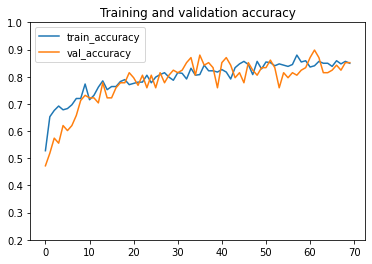

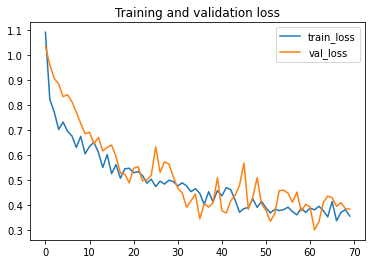

4/4 [==============================] - 1s 280ms/step - loss: 0.3380 - accuracy: 0.8796

batch size:  32
epochs:  70
learning rate:  1e-05


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


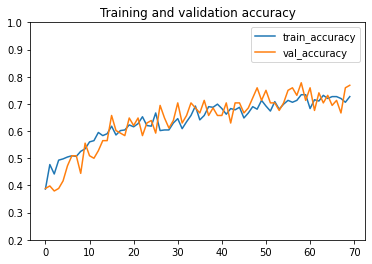

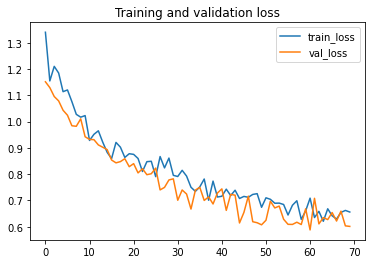

4/4 [==============================] - 1s 274ms/step - loss: 0.6453 - accuracy: 0.6852

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


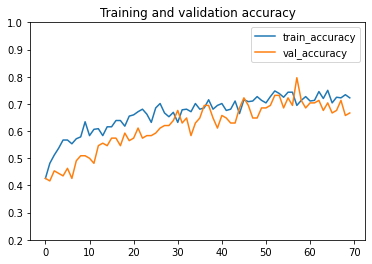

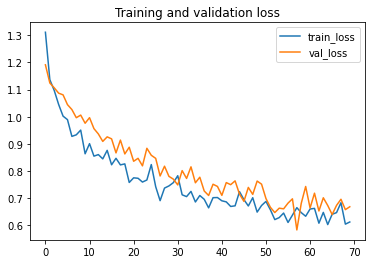

4/4 [==============================] - 1s 290ms/step - loss: 0.7510 - accuracy: 0.6481

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


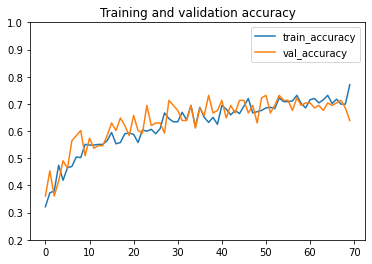

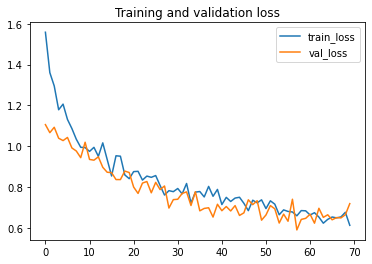

4/4 [==============================] - 1s 313ms/step - loss: 0.7266 - accuracy: 0.6759

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


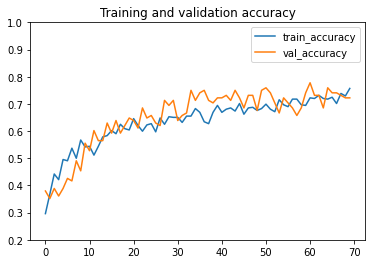

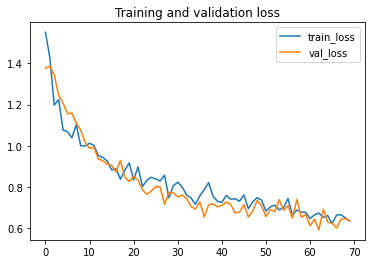

4/4 [==============================] - 1s 273ms/step - loss: 0.6139 - accuracy: 0.7315

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


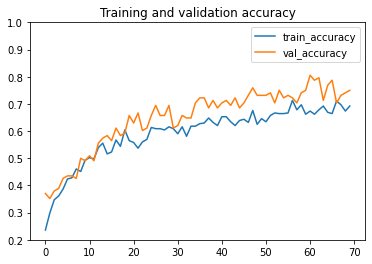

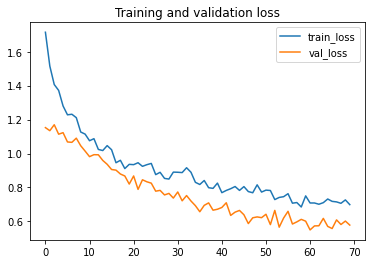

4/4 [==============================] - 1s 278ms/step - loss: 0.5715 - accuracy: 0.7222

batch size:  32
epochs:  90
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


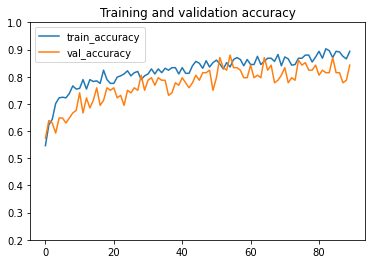

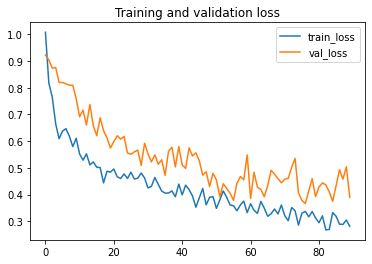

4/4 [==============================] - 1s 282ms/step - loss: 0.4141 - accuracy: 0.8426

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


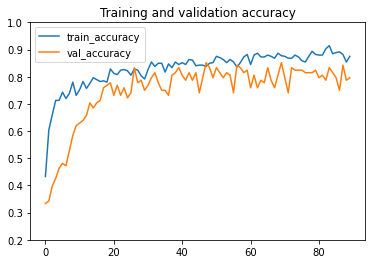

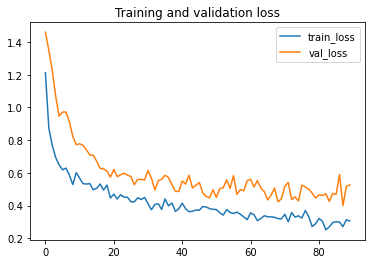

4/4 [==============================] - 1s 273ms/step - loss: 0.5231 - accuracy: 0.8241

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


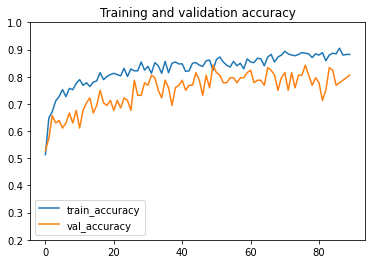

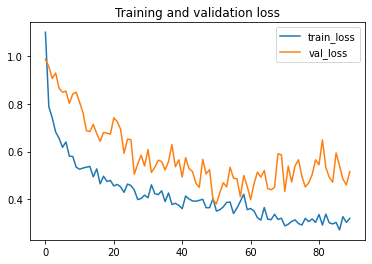

4/4 [==============================] - 1s 275ms/step - loss: 0.4511 - accuracy: 0.7778

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


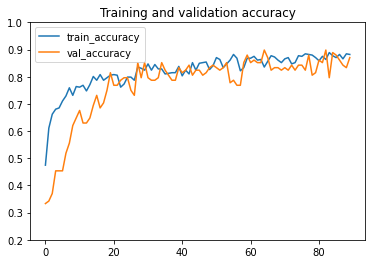

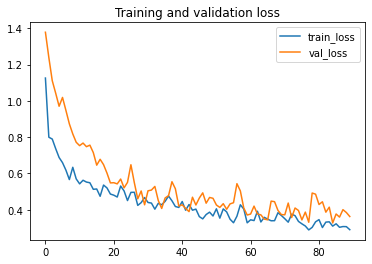

4/4 [==============================] - 1s 268ms/step - loss: 0.3192 - accuracy: 0.8889

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


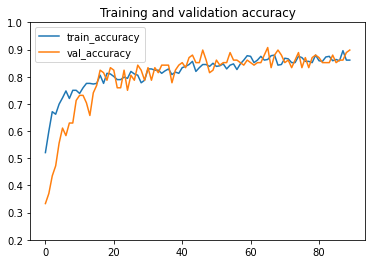

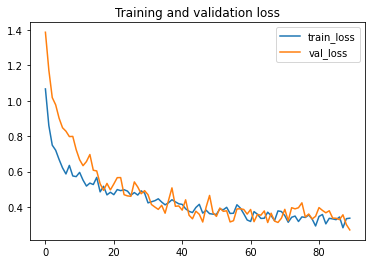

4/4 [==============================] - 1s 289ms/step - loss: 0.3159 - accuracy: 0.8611

batch size:  32
epochs:  90
learning rate:  1e-05


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


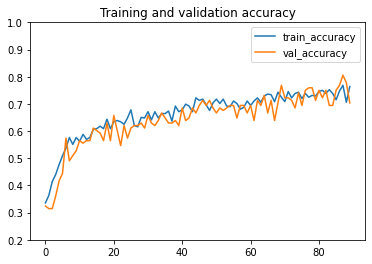

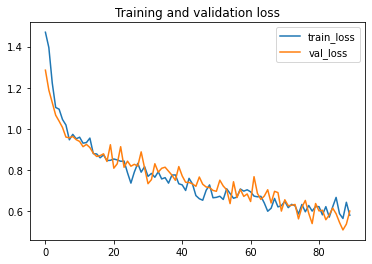

4/4 [==============================] - 1s 267ms/step - loss: 0.6223 - accuracy: 0.7500

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


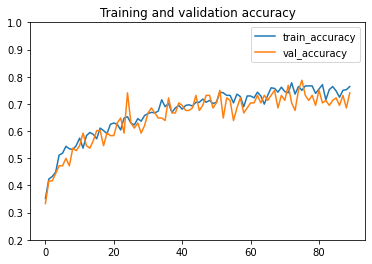

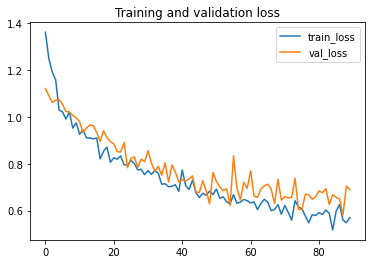

4/4 [==============================] - 1s 294ms/step - loss: 0.6379 - accuracy: 0.7037

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


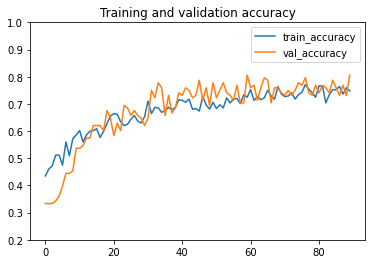

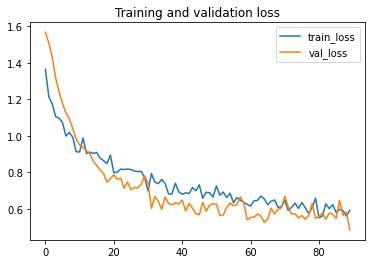

4/4 [==============================] - 1s 309ms/step - loss: 0.6017 - accuracy: 0.7407

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


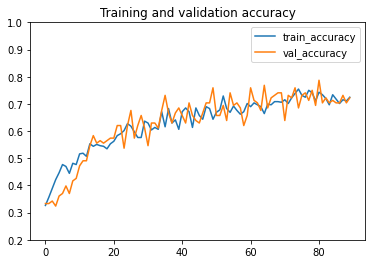

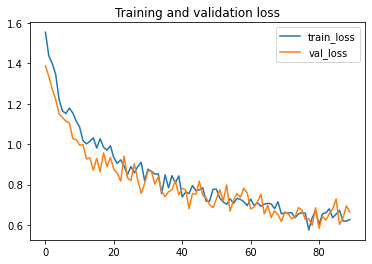

4/4 [==============================] - 1s 261ms/step - loss: 0.6375 - accuracy: 0.7500

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


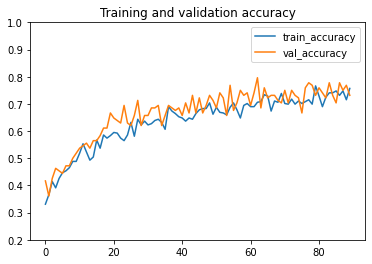

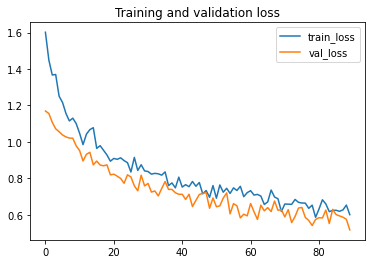

4/4 [==============================] - 1s 300ms/step - loss: 0.5751 - accuracy: 0.7870

batch size:  32
epochs:  110
learning rate:  0.0001


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


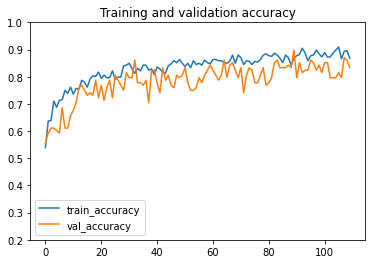

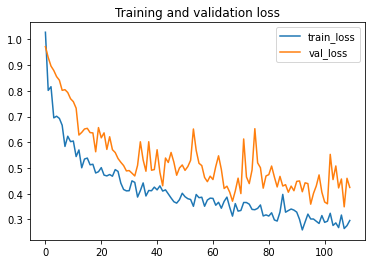

4/4 [==============================] - 1s 276ms/step - loss: 0.4342 - accuracy: 0.8148

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


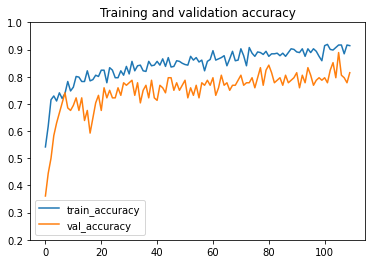

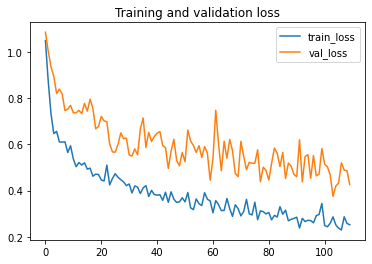

4/4 [==============================] - 1s 285ms/step - loss: 0.5022 - accuracy: 0.7870

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


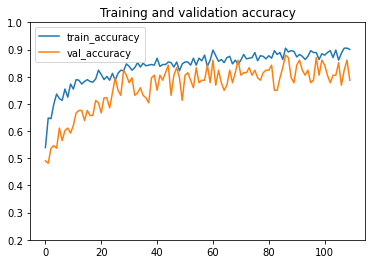

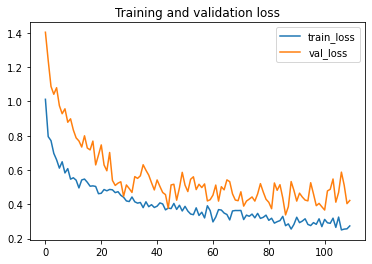

4/4 [==============================] - 1s 274ms/step - loss: 0.4697 - accuracy: 0.7778

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


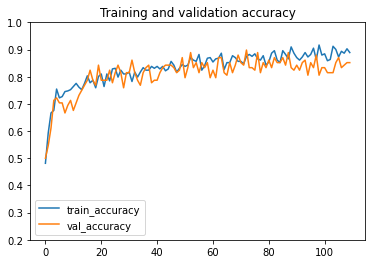

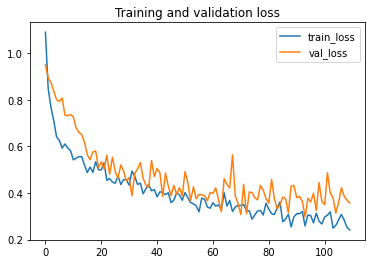

4/4 [==============================] - 1s 266ms/step - loss: 0.3523 - accuracy: 0.8333

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


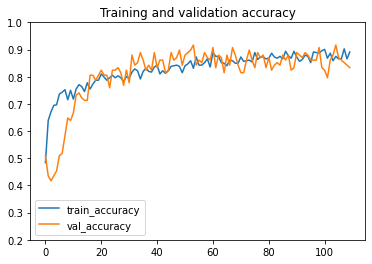

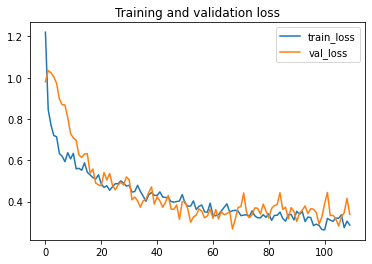

4/4 [==============================] - 1s 303ms/step - loss: 0.2897 - accuracy: 0.8981

batch size:  32
epochs:  110
learning rate:  1e-05


Fold number 1
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


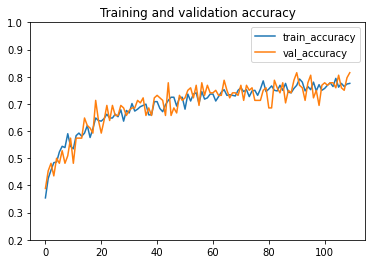

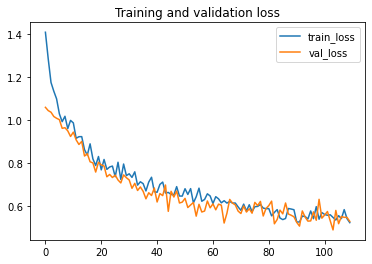

4/4 [==============================] - 1s 312ms/step - loss: 0.5592 - accuracy: 0.7407

Fold number 2
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


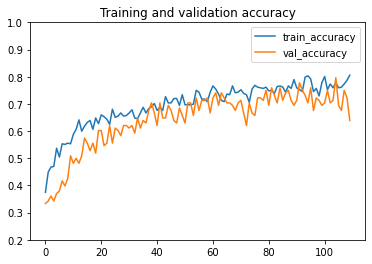

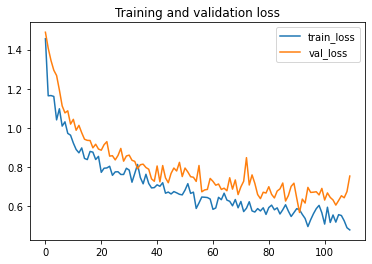

4/4 [==============================] - 1s 277ms/step - loss: 0.6523 - accuracy: 0.7037

Fold number 3
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


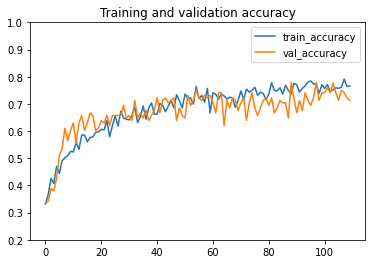

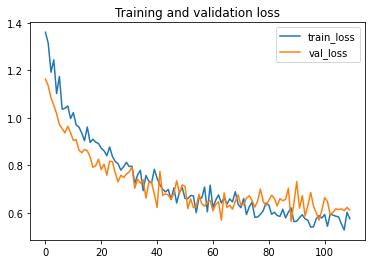

4/4 [==============================] - 1s 268ms/step - loss: 0.6222 - accuracy: 0.6852

Fold number 4
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


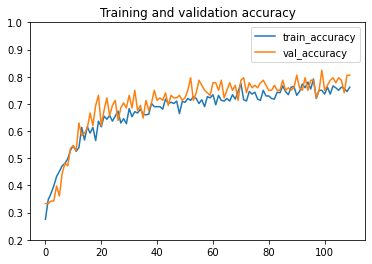

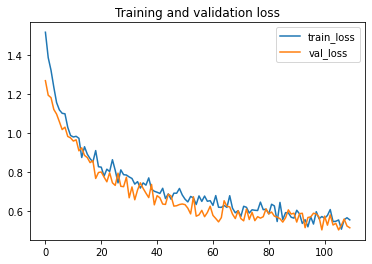

4/4 [==============================] - 1s 265ms/step - loss: 0.5025 - accuracy: 0.7778

Fold number 5
Found 432 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.


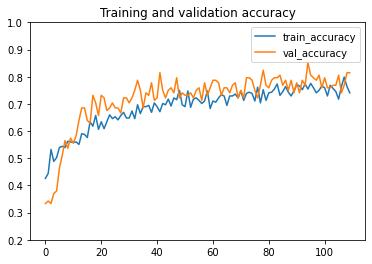

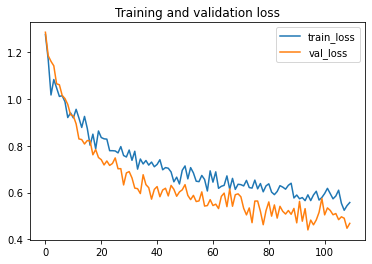

4/4 [==============================] - 1s 269ms/step - loss: 0.4853 - accuracy: 0.7778


In [15]:
for x in range(len(batch_size_arr)):
    
    #for batch size values
    if len(param_arr) == 0:
        param_arr.append([])
    
    for y in range(len(num_epochs_arr)):

        #for epoch values
        if len(param_arr) == 1:
            param_arr.append([])
        
        for z in range(len(lr_arr)):
            
            #for learning rate values
            if len(param_arr) == 2:
                param_arr.append([])
                
            print('')
            print("batch size: ", batch_size_arr[x])
            print("epochs: ", num_epochs_arr[y])
            print("learning rate: ", lr_arr[z])
            print('')
            
            #append the values per combo
            param_arr[0].append(batch_size_arr[x])
            param_arr[1].append(num_epochs_arr[y])
            param_arr[2].append(lr_arr[z])
            
            VALIDATION_ACCURACY = []
            VALIDATION_LOSS = []
            
            TRAIN_ACCURACY = []
            TRAIN_LOSS = []
            
            TEST_ACCURACY = []
            TEST_LOSS = []
            
            #change save_dir value per combination
            save_dir = savemodel()
            fold_var = 1
            
            for train_index, val_index in skf.split(np.zeros(len(df2)),Y):

                training_data = df2.iloc[train_index]
                validation_data = df2.iloc[val_index]
                
                print('')
                print("Fold number " + str(fold_var))
                
                train_data_generator = imgdatagen.flow_from_dataframe(training_data, directory = train_dir,
                                           x_col = "filename", y_col = "label",
                                          class_mode = "categorical", target_size = (224,224), batch_size = batch_size_arr[x],
                                            shuffle = True)
                valid_data_generator  = imgdatagen.flow_from_dataframe(validation_data, directory = train_dir,
                                        x_col = "filename", y_col = "label",
                                        class_mode = "categorical", target_size = (224,224), batch_size = batch_size_arr[x],
                                            shuffle = True)
                
                full_model = create_model()
                # Compile the model
                full_model.compile(loss='categorical_crossentropy',
                              optimizer=keras.optimizers.Adamax(learning_rate=lr_arr[z]),
                              metrics=['accuracy']) #categorical_crossentropy cause it is more than 2 classes

                # Create callbacks
                checkpoint = tf.keras.callbacks.ModelCheckpoint((save_dir+"/"+ "model_" + str(fold_var) + ".h5"), 
                                        monitor='val_loss', verbose=0, 
                                        save_best_only=True, mode='min')
                callbacks_list = [checkpoint]
                # This saves the best model


                # Fit the model
                history = full_model.fit(train_data_generator,
                                         epochs=num_epochs_arr[y],
                                         callbacks=callbacks_list,
                                         validation_data=valid_data_generator,
                                         verbose=0)

                # Plot the history
                plot_history(history, yrange=(0.2,1))

                # Load the best model instance to evaluate the performance of the model
                full_model.load_weights(save_dir+"/model_"+str(fold_var)+".h5")

                results = full_model.evaluate(valid_data_generator)
                results = dict(zip(full_model.metrics_names,results))

                # Store Validation accuracy/loss
                VALIDATION_ACCURACY.append(results['accuracy'])
                VALIDATION_LOSS.append(results['loss'])
                
                # Store Train accuracy/loss
                TRAIN_ACCURACY.append(np.mean(history.history['accuracy']))
                TRAIN_LOSS.append(np.mean(history.history['loss']))
                
                # Predict test set to get the test accuracy/loss
                yhat_probs = full_model.predict(testX, verbose=0)
                yhat_classes = yhat_probs.argmax(axis=-1)
                
                # Test accuracy and loss score
                accuracy = accuracy_score(yt, yhat_classes)
                loss = log_loss(yt, yhat_probs)
                
                # Store Test accuracy and loss
                TEST_ACCURACY.append(accuracy)
                TEST_LOSS.append(loss)
                
                tf.keras.backend.clear_session()

                fold_var += 1
                
            val_acc_arr.append(VALIDATION_ACCURACY)
            val_loss_arr.append(VALIDATION_LOSS)
            
            train_acc_arr.append(TRAIN_ACCURACY)                            
            train_loss_arr.append(TRAIN_LOSS)
            
            test_acc_arr.append(TEST_ACCURACY)
            test_loss_arr.append(TEST_LOSS)

### Display Values Per Combination of Parameters

We will put the combination of parameters and the resulting means of accuracy and loss together in a dataframe in order to display it nicely.

In [86]:
#append means of accuracy and loss sets per combo
for x in range(len(val_acc_arr)):
    val_acc_means.append(np.mean(val_acc_arr[x]))                                
    val_loss_means.append(np.mean(val_loss_arr[x]))
    
    train_acc_means.append(np.mean(train_acc_arr[x]))                              
    train_loss_means.append(np.mean(train_loss_arr[x]))                             

    test_acc_means.append(np.mean(test_acc_arr[x]))                               
    test_loss_means.append(np.mean(test_loss_arr[x])) 
    
df_hyperparam = pd.DataFrame(list(zip(param_arr[0],param_arr[1],param_arr[2],
                                      train_acc_means, train_loss_means,
                                      val_acc_means,val_loss_means,
                                      test_acc_means, test_loss_means))
                             ,columns=['batch size','number of epoch', 'learning rate', 
                                       'train accuracy', 'train loss',
                                       'val accuracy', 'val loss',
                                       'test accuracy', 'test loss'])

df_hyperparam = df_hyperparam.sort_values(ascending=True,by = 'val loss')

df_hyperparam.to_excel("hyperparam_result.xlsx")

df_hyperparam



batch size  number of epoch  learning rate  train accuracy  train loss  \
6            8              110        0.00010        0.807260    0.468395   
14          16              110        0.00010        0.831322    0.411268   
4            8               90        0.00010        0.796991    0.491454   
12          16               90        0.00010        0.819331    0.439244   
8           16               50        0.00010        0.787241    0.506134   
20          32               90        0.00010        0.824162    0.425994   
22          32              110        0.00010        0.834886    0.403699   
10          16               70        0.00010        0.807917    0.463435   
18          32               70        0.00010        0.805483    0.470540   
0            8               50        0.00010        0.764176    0.562095   
2            8               70        0.00010        0.782222    0.522159   
16          32               50        0.00010        0.790148    0.502475   
5            8               90        0.00001        0.670833    0.748987   
7            8              110        0.00001        0.676343    0.737426   
15          16              110        0.00001        0.696027    0.698672   
23          32              110        0.00001        0.686768    0.713208   
11          16               70        0.00001        0.658009    0.773874   
13          16               90        0.00001        0.675448    0.731402   
3            8               70        0.00001        0.650139    0.787753   
21          32               90        0.00001        0.655473    0.779964   
9           16               50        0.00001        0.627185    0.835384   
19          32               70        0.00001        0.630417    0.824414   
1            8               50        0.00001        0.622657    0.842969   
17          32               50        0.00001        0.611898    0.866385   

    val accuracy  val loss  test accuracy  test loss  
6       0.850000  0.357609       0.876667   0.292105  
14      0.848148  0.373343       0.860000   0.321981  
4       0.833333  0.383331       0.860000   0.331389  
12      0.846296  0.389362       0.853333   0.353269  
8       0.848148  0.404406       0.843333   0.365867  
20      0.838889  0.404675       0.830000   0.387990  
22      0.822222  0.409614       0.863333   0.341887  
10      0.842593  0.417136       0.853333   0.327493  
18      0.829630  0.434108       0.873333   0.378045  
0       0.825926  0.436351       0.866667   0.391070  
2       0.805556  0.445725       0.840000   0.378022  
16      0.818519  0.459602       0.843333   0.372300  
5       0.796296  0.516391       0.790000   0.512045  
7       0.792593  0.524770       0.780000   0.512430  
15      0.772222  0.545406       0.733333   0.562349  
23      0.737037  0.564315       0.776667   0.523743  
11      0.744444  0.582511       0.793333   0.547577  
13      0.748148  0.595232       0.763333   0.577960  
3       0.740741  0.602942       0.793333   0.561857  
21      0.746296  0.614908       0.750000   0.582837  
9       0.705556  0.634298       0.723333   0.639713  
19      0.692593  0.661683       0.713333   0.673988  
1       0.722222  0.672036       0.730000   0.657268  
17      0.681481  0.699346       0.716667   0.691752

### Each fold results of the best model

Below are the validation accuracy and validation loss per fold and their average of the best combination.

In [28]:
model_no = 6
fold_num = [*range(1,6)]

fold_eval = pd.DataFrame(list(zip(fold_num,train_acc_arr[model_no],train_loss_arr[model_no],
                                  val_acc_arr[model_no],val_loss_arr[model_no],
                                  test_acc_arr[model_no],test_loss_arr[model_no]))
                         ,columns=['fold','Training Accuracy','Training Loss',
                                   'Validation Accuracy','Validation Loss',
                                   'Test Accuracy','Test Loss'])

fold_eval.set_index('fold', inplace=True)
fold_eval.loc['mean'] = fold_eval.mean()

fold_eval.to_excel('fold_eval.xlsx')
fold_eval

Training Accuracy  Training Loss  Validation Accuracy  Validation Loss  \
fold                                                                           
1              0.809827       0.464794             0.833333         0.353710   
2              0.808838       0.465203             0.814815         0.391348   
3              0.810038       0.465645             0.888889         0.293921   
4              0.806145       0.468922             0.842593         0.385207   
5              0.801452       0.477409             0.870370         0.363858   
mean           0.807260       0.468395             0.850000         0.357609   

      Test Accuracy  Test Loss  
fold                            
1          0.833333   0.358493  
2          0.866667   0.285112  
3          0.916667   0.287680  
4          0.866667   0.269628  
5          0.900000   0.259609  
mean       0.876667   0.292105